## Final Project Submission

Please fill out:
* Student name: Wesley Yu
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Time Series Forecasting on House Prices

**Authors:** Wesley Yu
***

## Overview



The aim of this project is to identify the best zipcodes of New York City to invest in. 

To determine the criteria for best investment opportunity, I will examine profit margin of house prices within the last 3 years. Growth will not be the only focus. I will also examine price changes during 2007-2011 period, to assess risk. During this period average house prices dropped sharply due to the subprime mortgage crisis. Zipcodes less affected by this adverse economic event would be deemed less risky.

ARIMA model will be used for time series forecasting, using the below methodology:
* Differencing time series in order to achieve stationarity.
* Examining ACF and PACF plots to determine optimal AR and MA terms.
* Exhaustive search of different combination of terms to find optimal ARIMA model.
* Evaluating model and comparing forecasts with a simple baseline model.

## Business Problem



Identify the 5 best zipcodes in New York City to invest in, excluding Manhattan.

## Data Understanding



Dataset taken from Zillow, provides seasonally adjusted monthly median house prices of various zipcodes from April 1996 to April 2018. Full dataset contains information on 14,723 unique zipcodes.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the Data/Filtering for Chosen Zipcodes

In [2]:
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


Data frame contains information about each zipcode in wide format, with each row representing a unique zipcode. I will need to transform into long format later on in order to feed into model.

In [4]:
df[df.Metro == 'New York']['CountyName'].value_counts()

Suffolk        89
Bergen         65
Nassau         63
Westchester    61
Queens         55
Monmouth       47
Morris         43
Middlesex      34
Orange         30
Ocean          29
Kings          28
Union          26
Essex          25
Passaic        25
Dutchess       25
Rockland       23
Somerset       21
Hunterdon      18
Sussex         15
Hudson         13
Bronx          13
Richmond       12
Putnam          7
Pike            6
New York        6
Name: CountyName, dtype: int64

Main focus will be on four of the five boroughs of NYC. I will need to subset data to only those zipcodes.

In [5]:
ny_df = df[(df.Metro == 'New York')&(df.CountyName.isin(['Kings', 'Richmond', 'Queens', 'Bronx']))]

In [6]:
ny_df.shape

(108, 272)

There are a total of 106 zip codes within the 4 boroughs.

In [7]:
ny_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
35,61802,10462,New York,NY,New York,Bronx,36,154300.0,154300.0,154400.0,...,432800,436100,439900,443500,444100,443900,446000,446400,447200,450200


# Data Preprocessing

Checking for any null values in data.

In [8]:
ny_df.iloc[:, 0:7].isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
dtype: int64

No missing values found in the first 7 columns.

In [9]:
ny_df.iloc[:, 7:].isnull().sum()

1996-04    6
1996-05    6
1996-06    6
1996-07    6
1996-08    6
          ..
2017-12    0
2018-01    0
2018-02    0
2018-03    0
2018-04    0
Length: 265, dtype: int64

Some zip codes have null values in certain periods.

In [10]:
ny_df.iloc[:, 7:].isnull().sum().sum()

768

There are a total of 768 missing values from various time periods.

In [11]:
ny_df[ny_df['1996-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
1299,62004,11101,New York,NY,New York,Queens,1300,NaN,NaN,NaN,...,760100,739000,708300,698500,711200,742900,767300,769700,767200,782500
1413,61799,10459,New York,NY,New York,Bronx,1414,NaN,NaN,NaN,...,337200,334600,328700,332200,349300,370100,383000,393400,403900,410400
1434,62016,11205,New York,NY,New York,Kings,1435,NaN,NaN,NaN,...,2267400,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400
1534,62028,11217,New York,NY,New York,Kings,1535,NaN,NaN,NaN,...,3405900,3442900,3443800,3426000,3407000,3404100,3413800,3482900,3588100,3656000


After closer examination missing values seem to be only at the earlier periods.

In [12]:
ny_df[ny_df['1996-04'].isna()].isna().sum(axis = 1)

36      213
156      93
1299    189
1413     87
1434     93
1534     93
dtype: int64

10456 and 11101 are some missing values from the period I plan to exam, 2011 and onwards. I will drop them from data frame. 

In [13]:
ny_df.drop(index = [36, 1299], inplace = True)

C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# EDA and Visualization

First step will be to examine the general change in prices over the entire period. I will examine the average of all zipcodes within the four selected boroughs.

In [14]:
ny_df_mean = ny_df.iloc[:, 7:].mean() # compute values for average price of all zipcodes in our subset

In [15]:
ny_df_mean.index = pd.to_datetime(ny_df_mean.index)

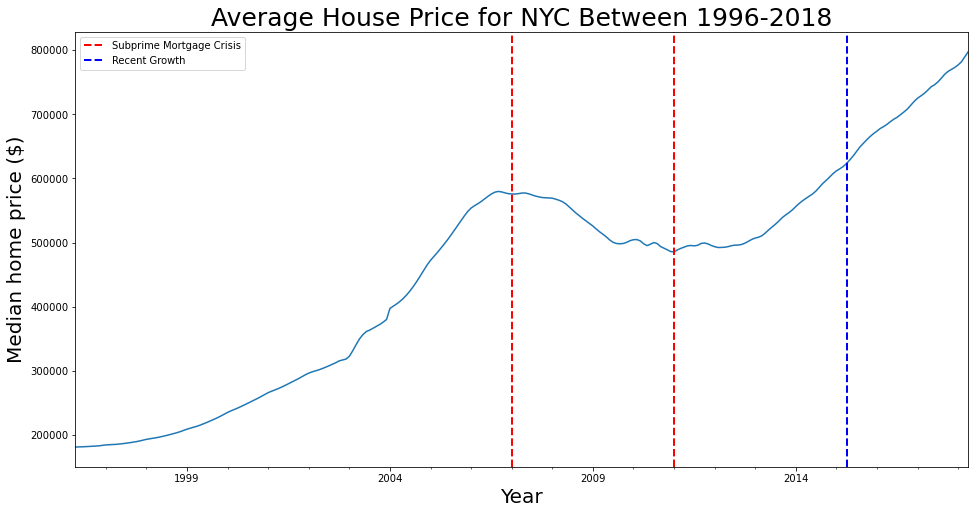

In [16]:
plt.figure(figsize=(16,8))
ny_df_mean.plot(label = '_nolegend_')
plt.title('Average House Price for NYC Between 1996-2018', fontsize = 25)
plt.ylabel('Median home price ($)', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.axvline(pd.to_datetime('2007-01-01'), color = 'r', linestyle='--', lw=2, label = 'Subprime Mortgage Crisis')
plt.axvline(pd.to_datetime('2011-01-01'), color = 'r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2015-04-01'), color = 'b', linestyle='--', lw=2, label = 'Recent Growth')
plt.legend();

Average prices show a decline starting around 2007 and start to rise again after 2011, which can be explain by the subprime mortgage crisis. For modeling I will use values from 2011 onward to forecast for future prices.

<AxesSubplot:>

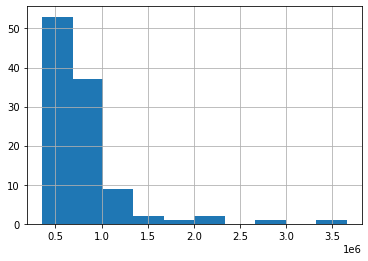

In [17]:
ny_df['2018-04'].hist()

In [18]:
ny_df['2018-04'].describe()

count    1.060000e+02
mean     7.976717e+05
std      4.903511e+05
min      3.567000e+05
25%      4.916750e+05
50%      6.859000e+05
75%      9.172500e+05
max      3.656000e+06
Name: 2018-04, dtype: float64

Majority of house prices available during April 2018 are under 1 million. 

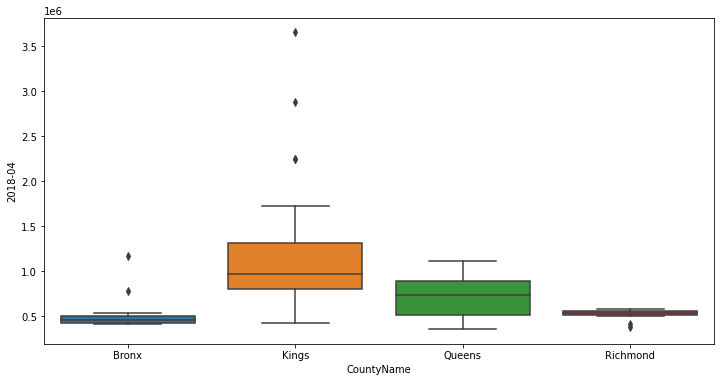

In [19]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '2018-04', data = ny_df);

Kings county has higher average house prices compared to others.

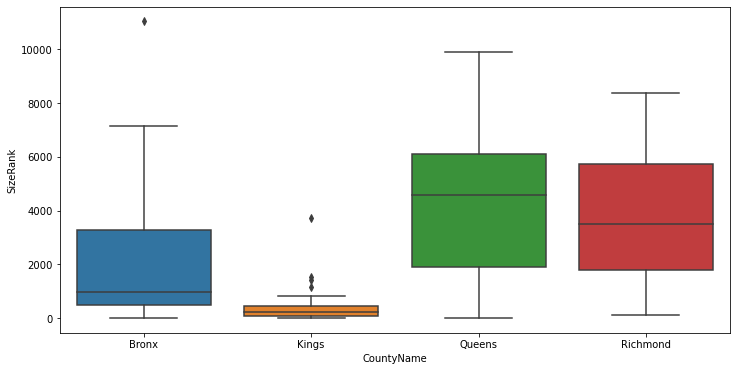

In [20]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = 'SizeRank', data = ny_df);

I assume SizeRank ranks each zipcode based on population density. Kings county also contains more densely populated zip codes compared to others.

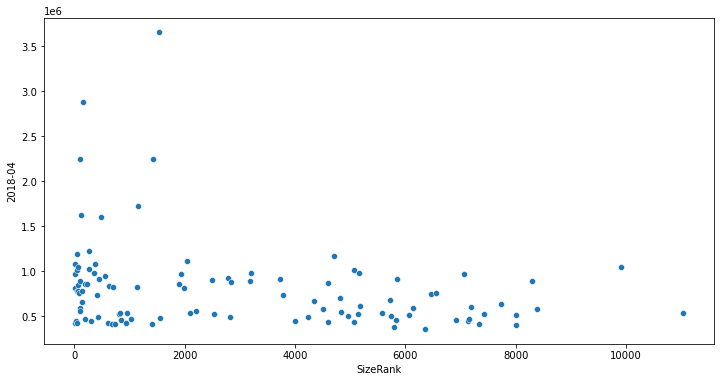

In [21]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'SizeRank', y = '2018-04', data = ny_df);

A few zipcodes with high average house prices are also ranked high on SizeRank, but there does not seem to be a strong correlation between the two.

In [22]:
ny_df['3_yr_roi'] = (ny_df['2018-04'] - ny_df['2015-04']) / ny_df['2015-04']

<ipython-input-22-de911f5f8043>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df['3_yr_roi'] = (ny_df['2018-04'] - ny_df['2015-04']) / ny_df['2015-04']


To determine a criteria for best zipcode to invest in, I created a new variable which will represent the ROI based on cost 3 years ago.

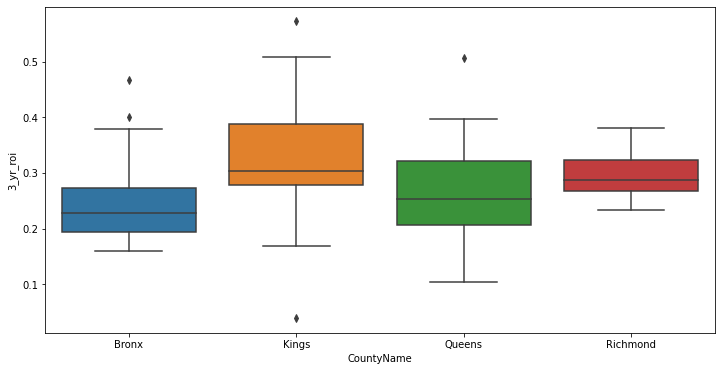

In [23]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '3_yr_roi', data = ny_df);

Kings county has higher 3_yr_roi compared to others.

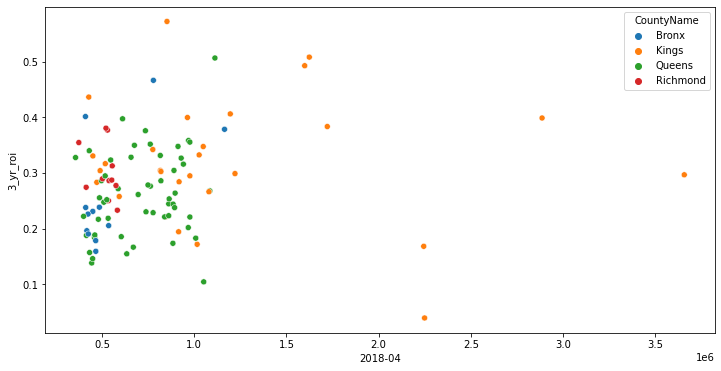

In [24]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '2018-04', y = '3_yr_roi', hue = 'CountyName', data = ny_df);

Median house prices does not seem to have any correlation with 3_yr_roi.

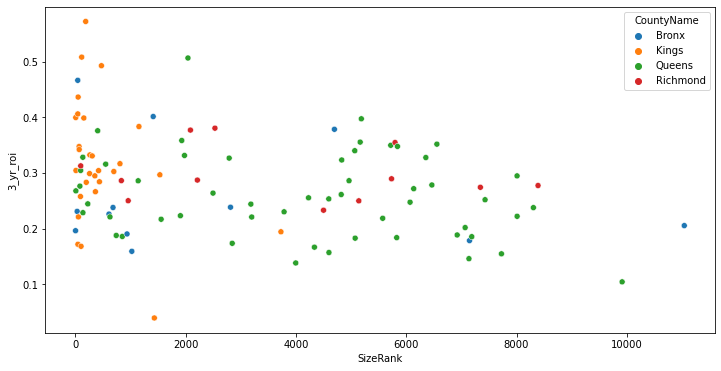

In [25]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'SizeRank', y = '3_yr_roi',  hue = 'CountyName', data = ny_df);

SizeRank does not seem to have any correlation with 3_yr_roi.

<AxesSubplot:>

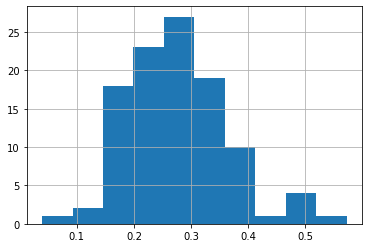

In [26]:
ny_df['3_yr_roi'].hist()

In [27]:
ny_df['3_yr_roi'].describe()

count    106.000000
mean       0.279379
std        0.090118
min        0.039290
25%        0.220862
50%        0.275110
75%        0.331004
max        0.571929
Name: 3_yr_roi, dtype: float64

Investing in any zipcode 3 years ago would have returned profit. 

In [28]:
ny_df.sort_values('3_yr_roi', ascending = False).head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,3_yr_roi
190,62043,11233,New York,NY,New York,Kings,191,124500.0,124500.0,124500.0,...,788000,787100,797100,808400,809800,800800,806100,829200,852300,0.571929
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,0.507894
2043,62005,11102,New York,NY,New York,Queens,2044,168600.0,169500.0,170400.0,...,1015800,1010800,1008000,1027500,1053700,1071500,1072700,1088200,1112100,0.506298
475,62027,11216,New York,NY,New York,Kings,476,146100.0,146600.0,147200.0,...,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,0.492438
46,61803,10463,New York,NY,New York,Bronx,47,180100.0,181000.0,181900.0,...,684500,692000,700900,710200,726900,744500,757000,769400,778700,0.466202
53,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,0.436138
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,0.405857
1413,61799,10459,New York,NY,New York,Bronx,1414,NaN,NaN,NaN,...,334600,328700,332200,349300,370100,383000,393400,403900,410400,0.401161
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,0.399390
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300,0.398526


Top 10 zipcodes based on 3_yr_roi.

In [29]:
ny_df['07_11_roi'] = (ny_df['2011-01'] - ny_df['2007-01']) / ny_df['2007-01']

<ipython-input-29-bd7c3a8cb904>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df['07_11_roi'] = (ny_df['2011-01'] - ny_df['2007-01']) / ny_df['2007-01']


From the previous plot of the average prices, there has been a steady rise since 2011. I created another variable 07_11_roi, which will measure the ROI from 2007 to 2011. Average house prices we on the decline during this period. The idea is that zipcodes with the lowest decline during the subprime mortgage crisis show resilience to adverse economical events. 

<AxesSubplot:>

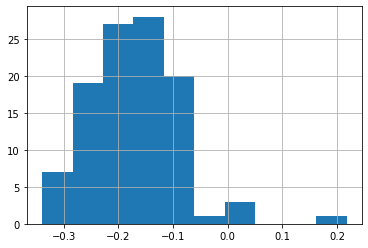

In [30]:
ny_df['07_11_roi'].hist()

In [31]:
ny_df['07_11_roi'].describe()

count    106.000000
mean      -0.170074
std        0.080123
min       -0.339659
25%       -0.224847
50%       -0.170140
75%       -0.118981
max        0.217395
Name: 07_11_roi, dtype: float64

Majority of zipcodes have negative ROI, while a few were able to return a profit.

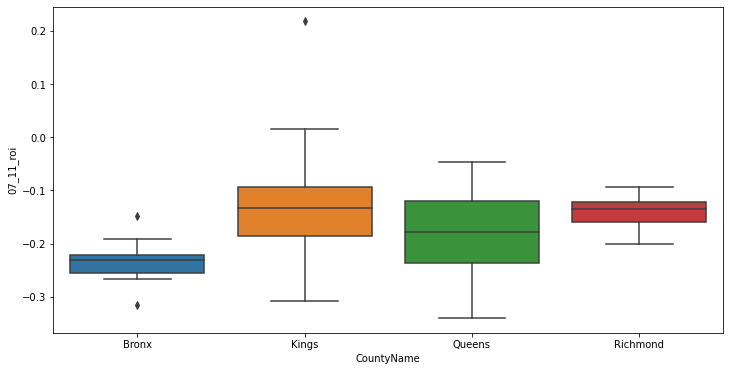

In [32]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '07_11_roi', data = ny_df);

Kings county had higher average returns compared to others from 2007-2011.

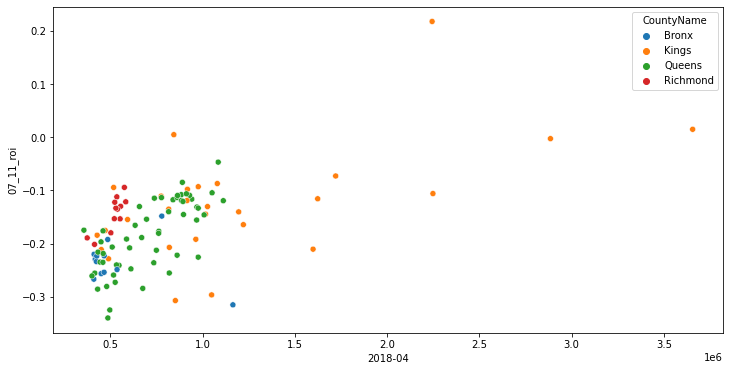

In [33]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '2018-04', y = '07_11_roi', hue = 'CountyName', data = ny_df);

Higher median house price zipcodes seem to be less affected from the 07-11 crisis.

In [34]:
ny_df[(ny_df['07_11_roi'] > -0.118) & (ny_df['3_yr_roi'] > 0.33)]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,3_yr_roi,07_11_roi
72,62039,11229,New York,NY,New York,Kings,73,183900.0,184200.0,184500.0,...,734500,735500,736100,741000,748100,755800,766200,775500,0.341928,-0.110645
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,0.507894,-0.115706
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300,0.398526,-0.002756
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,0.383187,-0.072898
5840,62182,11694,New York,NY,New York,Queens,5841,285700.0,286600.0,287600.0,...,874400,880400,880900,885800,893000,896400,902900,912100,0.347466,-0.106343


Filtering zipcodes by having both 07_11_roi and 3_yr_roi greater than their respective 75th percentiles return only 5 zipcodes that satisfy these requirements. To include a few more zipcdoes for further analysis, I examine a plot of 07_11_roi and 3_yr_roi to find zipcodes with the highest values of both variables.

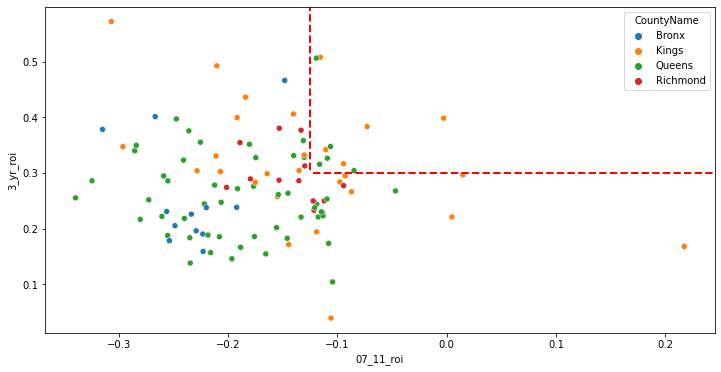

In [35]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '07_11_roi', y = '3_yr_roi', hue = 'CountyName', data = ny_df)
plt.axvline(x = -0.125, ymin = 0.5, color = 'r', linestyle='--', lw=2)
plt.axhline(y = 0.3, xmin = 0.4, color = 'r', linestyle='--', lw=2);

In [36]:
top10 = ny_df[(ny_df['07_11_roi'] > -0.125) & (ny_df['3_yr_roi'] > 0.3)]

In [37]:
top10

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,3_yr_roi,07_11_roi
72,62039,11229,New York,NY,New York,Kings,73,183900.0,184200.0,184500.0,...,734500,735500,736100,741000,748100,755800,766200,775500,0.341928,-0.110645
99,62067,11355,New York,NY,New York,Queens,100,182800.0,182500.0,182300.0,...,853000,859500,865500,871400,875900,877300,882400,890200,0.304322,-0.084823
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,0.507894,-0.115706
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300,0.398526,-0.002756
552,62066,11354,New York,NY,New York,Queens,553,225300.0,226500.0,227800.0,...,892400,903100,911000,916500,923500,929900,935700,941200,0.315628,-0.116371
811,62035,11224,New York,NY,New York,Kings,812,158000.0,157300.0,156700.0,...,490800,494400,496000,498700,502000,505600,511600,517900,0.316472,-0.094418
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,0.383187,-0.072898
2043,62005,11102,New York,NY,New York,Queens,2044,168600.0,169500.0,170400.0,...,1010800,1008000,1027500,1053700,1071500,1072700,1088200,1112100,0.506298,-0.119327
2790,62008,11105,New York,NY,New York,Queens,2791,185700.0,186300.0,187000.0,...,911800,915900,912800,900800,897900,904900,918000,929200,0.326481,-0.109234
5840,62182,11694,New York,NY,New York,Queens,5841,285700.0,286600.0,287600.0,...,874400,880400,880900,885800,893000,896400,902900,912100,0.347466,-0.106343


Now I have a list of top 10 zipcodes with 3 year ROI and most stable median prices during 2007-2011.

In [38]:
top10.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', '3_yr_roi', '07_11_roi'], axis = 1, inplace = True)

C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Dropped columns that are not needed.

In [39]:
top10

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
72,11229,183900.0,184200.0,184500.0,184800.0,185000.0,185100.0,185400.0,185600.0,186200.0,...,724100,730300,734500,735500,736100,741000,748100,755800,766200,775500
99,11355,182800.0,182500.0,182300.0,182100.0,181900.0,181800.0,181700.0,181900.0,182300.0,...,842400,847300,853000,859500,865500,871400,875900,877300,882400,890200
117,11211,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,131800.0,132400.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700
156,11238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
552,11354,225300.0,226500.0,227800.0,229200.0,230700.0,232100.0,233500.0,235000.0,236700.0,...,872100,880900,892400,903100,911000,916500,923500,929900,935700,941200
811,11224,158000.0,157300.0,156700.0,156100.0,155600.0,155000.0,154400.0,153700.0,153000.0,...,477800,484900,490800,494400,496000,498700,502000,505600,511600,517900
1155,11222,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,145600.0,146100.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
2043,11102,168600.0,169500.0,170400.0,171400.0,172500.0,173600.0,174700.0,176100.0,177700.0,...,1013200,1015800,1010800,1008000,1027500,1053700,1071500,1072700,1088200,1112100
2790,11105,185700.0,186300.0,187000.0,187800.0,188700.0,189500.0,190300.0,191200.0,192400.0,...,911000,908900,911800,915900,912800,900800,897900,904900,918000,929200
5840,11694,285700.0,286600.0,287600.0,288600.0,289900.0,291600.0,293400.0,295600.0,298000.0,...,849400,860900,874400,880400,880900,885800,893000,896400,902900,912100


# Reshape from Wide to Long Format

Before I can start analysis on time series, it will be helpful to transform data into long format.

In [40]:
def melt_data(df, zipcode):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    """
    
    melted = pd.melt(df[df['RegionName'] == zipcode], id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.drop('RegionName', axis = 1, inplace = True)
    melted.set_index('time', inplace = True)
    return melted

In [41]:
ts_11355 = melt_data(top10, 11355)

In [42]:
ts_11355

,value
time,
1996-04-01,182800.0
1996-05-01,182500.0
1996-06-01,182300.0
1996-07-01,182100.0
1996-08-01,181900.0
...,...
2017-12-01,871400.0
2018-01-01,875900.0
2018-02-01,877300.0


# ARIMA Modeling

To establish a baseline to compare my ARIMA results, I create a naive forecast function. This assumes prices of the next period is the price that was observed in the previous period.

In [43]:
def shifted_rmse(ts):
    shifted_ts = ts.shift() # creates naive forecasts by shifting time series one period ahead.
    # setting test dataset to the last avaliable whole year in data.
    prediction = shifted_ts['2017-05-01':].value 
    test = ts['2017-05-01':].value
    
    rmse = np.sqrt(mean_squared_error(test, prediction)) # calculating rmse for baseline.
    
    prediction.plot(label = 'Prediction', legend = True)
    test.plot(label = 'Observed', legend = True);
    
    print('RMSE: ' + str(rmse))

## 11355

RMSE: 6087.350271943725


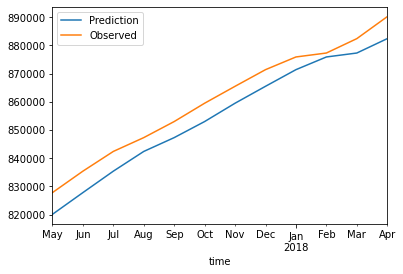

In [44]:
shifted_rmse(ts_11355)

Splitting data into train and test sets. Holding out the last 12 periods for testing trained forecasts.

In [45]:
train_11355 = ts_11355['2011-01':'2017-04']
test_11355 = ts_11355['2017-05':]

In [46]:
train_11355

,value
time,
2011-01-01,522200.0
2011-02-01,523300.0
2011-03-01,523100.0
2011-04-01,524100.0
2011-05-01,527300.0
...,...
2016-12-01,804700.0
2017-01-01,809800.0
2017-02-01,812000.0


In [47]:
test_11355

,value
time,
2017-05-01,827800.0
2017-06-01,835400.0
2017-07-01,842400.0
2017-08-01,847300.0
2017-09-01,853000.0
2017-10-01,859500.0
2017-11-01,865500.0
2017-12-01,871400.0
2018-01-01,875900.0


Ideally it is best to have a stationary time series for modeling. This can be checked both visually and usign a unit root test such as ADF.

In [48]:
def stationarity_check(data):
    # computing the rolling mean and std of time series
    roll_mean = data.rolling(window = 12, center = False).mean() 
    roll_std = data.rolling(window = 12, center = False).std()
    
    # plotting time series with rolling mean and std
    fig = plt.figure(figsize=(12,7))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # run ADF test
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

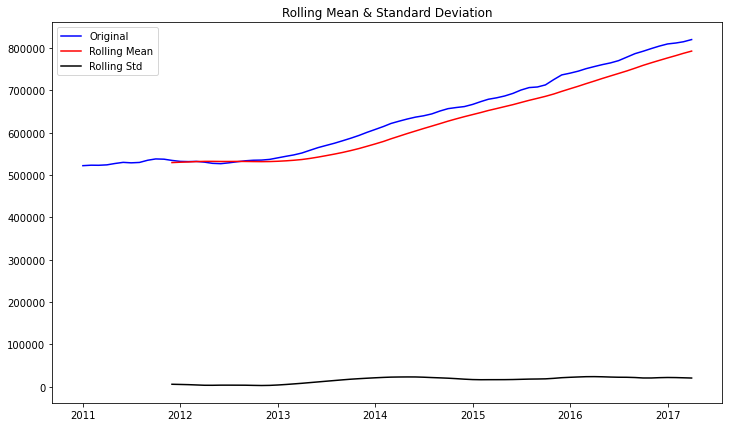

Test Statistic                  0.281953
p-value                         0.976501
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

In [49]:
stationarity_check(train_11355)

As expected of seasonally adjusted data, time series plot does not show any seasonality. We can see a general upward trend over time.

Initial time series is not stationary. P-value of ADF test is high and we can see an upward trend in the rolling mean. Time series can be made stationary by differencing.

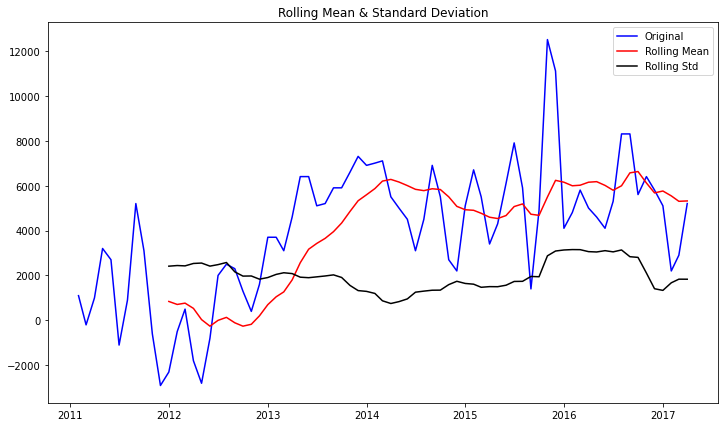

Test Statistic                 -1.781503
p-value                         0.389683
#Lags Used                      2.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

In [50]:
stationarity_check(train_11355.diff().dropna())

After first order differencing, p-value has dropped to 0.38. But this will still be above default threshold levels of 0.05. Another order of differencing can be applied.

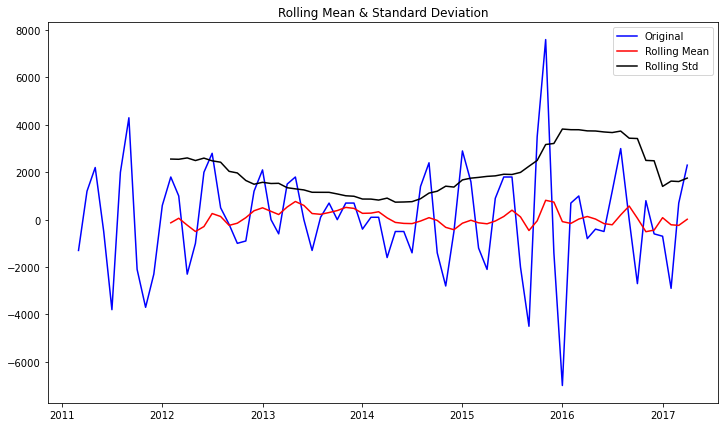

Test Statistic                 -4.666796
p-value                         0.000097
#Lags Used                      6.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [51]:
stationarity_check(train_11355.diff().diff().dropna())

After second order differencing, time series looks stationary now. P-value is very small and rolling std and means are somewhat constant.

To determine the order of AR and MA terms in ARIMA model, we can examine the PACF plots and ACF plots of the time series.

In [52]:
ts_diff = train_11355.diff().diff().dropna()

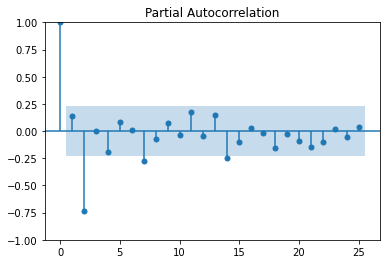

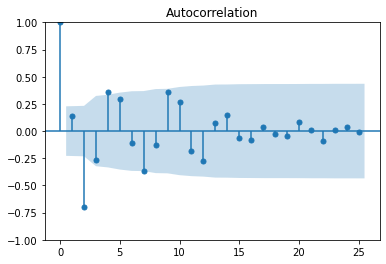

In [53]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

PACF plot shows a spike at lag 2 greater than the 95% interval and smaller spikes at 7 and 14. We can try an AR term of 2. ACF plot shows a spike at lag 2, which indicates we can try a MA term of 2.

AR(2) and MA(2) are found to be good starting points for determining the optimal order of ARIMA model. With the auto_arima library, I can run a grid search to determine the best AR and MA terms by comparing the model's AIC.

In [54]:
model_11355 = auto_arima(train_11355,
                             max_p=2, max_q=2, seasonal = False,
                            trace=True,
                            test = 'adf', 
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to False to for exhaustive search

                   
model_11355.fit(train_11355)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1348.374, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1349.947, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1357.159, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1349.887, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1351.884, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1361.805, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1381.017, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1379.741, Time=0.10 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1340.323, Time=0.38 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 0.940 seconds


ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True)

ARIMA order (2,2,2) with intercept term was found to be the best fit model.

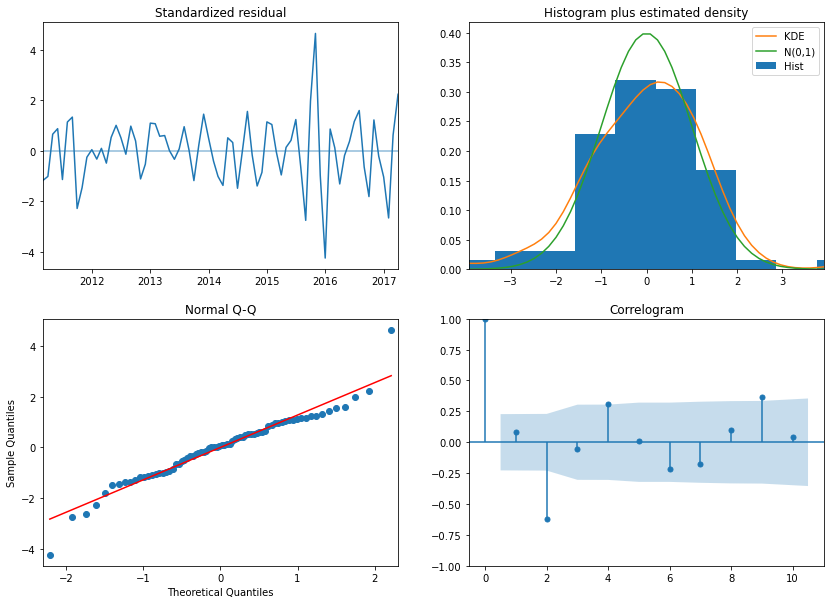

In [55]:
model_11355.plot_diagnostics(figsize=(14,10));

Model diagnostics used to check assumptions of time series model has been satisfied.
Top left shows residuals are centered around mean of zero.
Top right displays the density plot which shows normal distribution.
Bottom left QQ plot also shows residuals appear normally distributed.
Bottom right shows the ACF plot of residuals. There are some significant spikes at lags 2, 4, and 9 which indicate that there are some patterns not explained by the model. Since model is univariate time series we can try to add some additional predictors in the future to try to explain these patterns.

In [56]:
# forecast values to compare with test set
prediction, confint = model_11355.predict(n_periods=12, return_conf_int=True)

prediction 

2017-05-01    825012.940460
2017-06-01    830583.661601
2017-07-01    836872.373338
2017-08-01    842998.765681
2017-09-01    848385.573121
2017-10-01    853545.775958
2017-11-01    859341.278394
2017-12-01    865782.922865
2018-01-01    872041.686348
2018-02-01    877618.385072
2018-03-01    883022.314570
2018-04-01    889037.525079
Freq: MS, dtype: float64

4310.58573936286

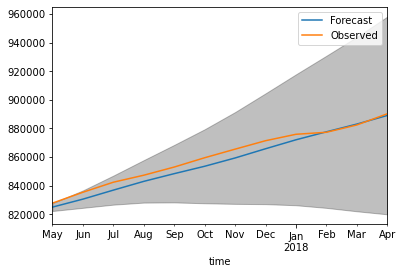

In [57]:
# plot forecasted test values and confidence intervals with observed test values 
fig, ax = plt.subplots()
prediction.plot(label = 'Forecast', legend = True, ax = ax)
test_11355.plot(y = 'value', label = 'Observed', legend = True, ax=ax)
ax.fill_between(prediction.index,
                confint[:,0],
                confint[:,1], color='k', alpha=0.25);
    
np.sqrt(mean_squared_error(test_11355, prediction))

Trained ARIMA model was able to forecast better than the baseline.

In [58]:
model_results = pd.DataFrame(columns=['Zipcode', 'base_rmse', 'forecast_rmse'])
model_results = model_results.append({'Zipcode': '11355',
                                      'base_rmse': 6087.35,
                                      'forecast_rmse': 4310.58}, ignore_index = True)

Creating some helper functions to reduce amount of coding needed for other zipcodes.

In [59]:
def split(df, zipcode):
    '''
    This will convert selected zipcode into long format and split into train
    test sets.
    '''
    ts = melt_data(df, zipcode)
    train = ts['2011-01':'2017-04']
    test = ts['2017-05':]
    return ts, train, test

In [60]:
def aa_model(train, p, q):
    '''
    Run auto_arima with specified AR and MA terms.
    '''
    model = auto_arima(train,
                       max_p=p, 
                       max_q=q, 
                       seasonal = False,
                       start_p = 0, 
                       start_q = 0,
                       trace=True,
                       test = 'adf', # use ADF test to determine order of differencing
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=False)  # set to False to for exhaustive search
    model.fit(train)
    model.plot_diagnostics(figsize = (14,10));
    return model

In [61]:
def forecast_rmse(model, test):
    '''
    Takes in ARIMA model and makes forecast. 
    Plot forecast with oberserved values and calculate rmse.
    '''
    prediction, confint = model.predict(n_periods=12, return_conf_int=True)
    
    fig, ax = plt.subplots()
    
    prediction.plot(label = 'Forecast', legend = True, ax = ax)
    test.plot(y = 'value', label = 'Observed', legend = True, ax = ax)
    ax.fill_between(prediction.index,
                confint[:,0],
                confint[:,1], color='k', alpha=0.25);
    
    rmse = np.sqrt(mean_squared_error(test, prediction))
    
    print('RMSE: ' + str(rmse))

## 11354

In [62]:
ts_11354, train_11354, test_11354 = split(top10, 11354)

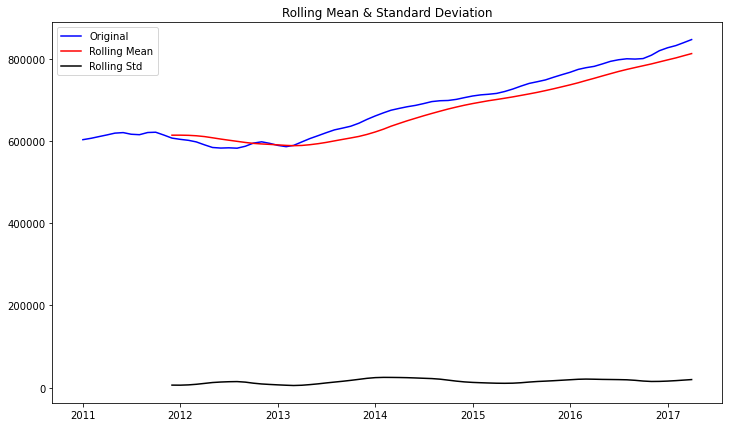

Test Statistic                  1.113323
p-value                         0.995329
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [63]:
stationarity_check(train_11354)

Making use of ndiffs to determine order of differencing needed to make time series stationary.

In [64]:
ndiffs(train_11354, test='adf')  

2

In [65]:
ts_diff = train_11354.diff().diff().dropna()

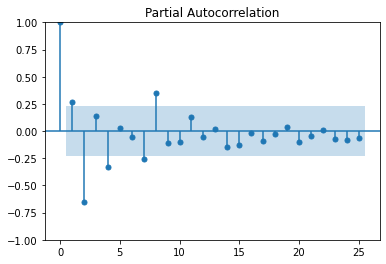

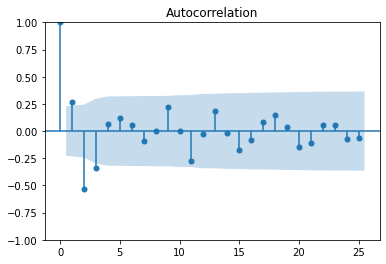

In [66]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

PACF shows several significant spikes at lags 1, 2, 4, 7, and 8.
ACF shows spikes at lags 1, 2, 3.
Auto_arima defaults to a maximum of 5 AR + MA terms. It is possible that higher AR and MA terms will fit better, but can result in over fitting. I will use a max of AR(4) and MA(3).

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1390.923, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1393.631, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1403.411, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1444.728, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1393.074, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1395.645, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1414.525, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1446.127, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1412.105, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1415.628, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1437.033, Time=0.38 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1440.051, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1414.288, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1417.290, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1386.880, Time=0.40 sec
 ARIMA(4,2

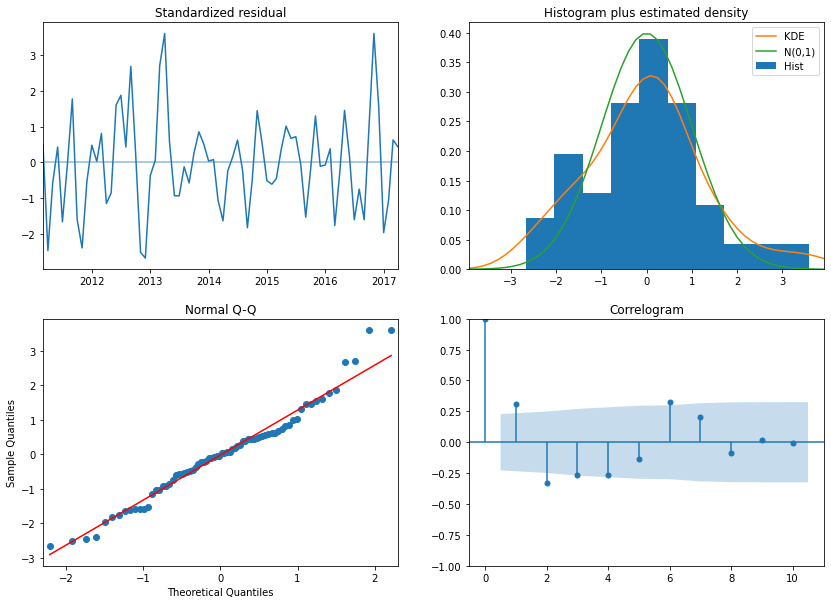

In [67]:
model_11354 = aa_model(train_11354, 4, 3)

Correlogram shows some auto correlation in the residuals.

RMSE: 5819.318384738266


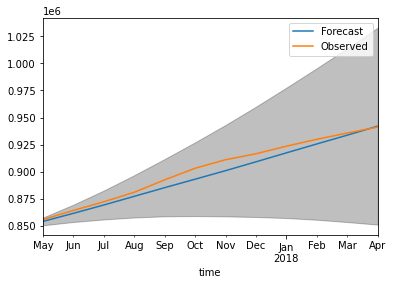

In [68]:
forecast_rmse(model_11354, test_11354)

RMSE: 8132.291599953033


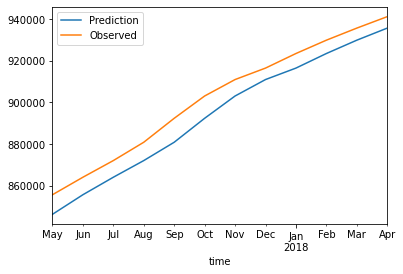

In [69]:
shifted_rmse(ts_11354)

ARIMA model performed better than baseline.

In [70]:
model_results = model_results.append({'Zipcode': '11354',
                                      'forecast_rmse': 5819.31,
                                      'base_rmse': 8132.29}, ignore_index = True)


## 11224

In [71]:
ts_11224, train_11224, test_11224 = split(top10, 11224)

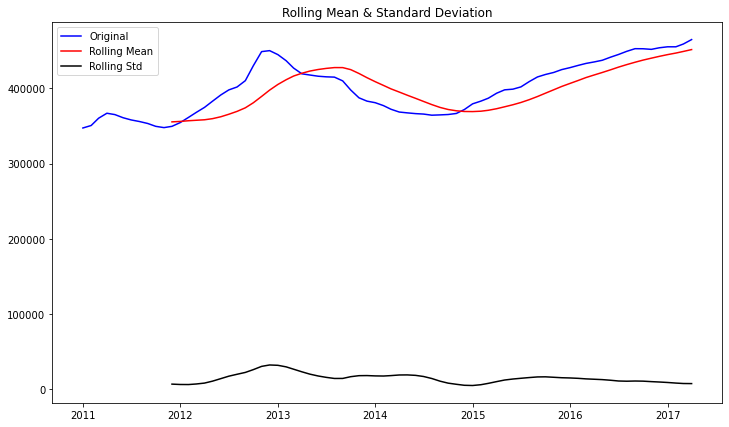

Test Statistic                 -2.127971
p-value                         0.233417
#Lags Used                      9.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

In [72]:
stationarity_check(train_11224)

In [73]:
ndiffs(train_11224, test='adf')  

2

In [74]:
ts_diff = train_11224.diff().diff().dropna()

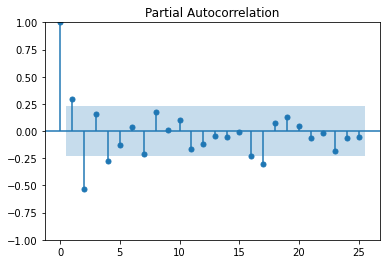

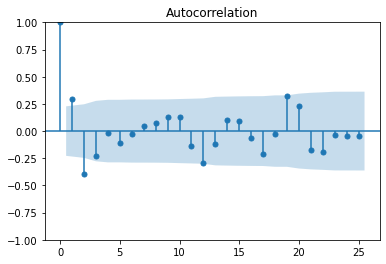

In [75]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1429.129, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1432.513, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1434.238, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1429.285, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1434.446, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1436.448, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1440.819, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1441.600, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1419.191, Time=0.30 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1438.096, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1439.412, Time=0.12 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1426.145, Time=0.30 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1444.443, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1445.469, Time=0.17 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 1.670 seconds

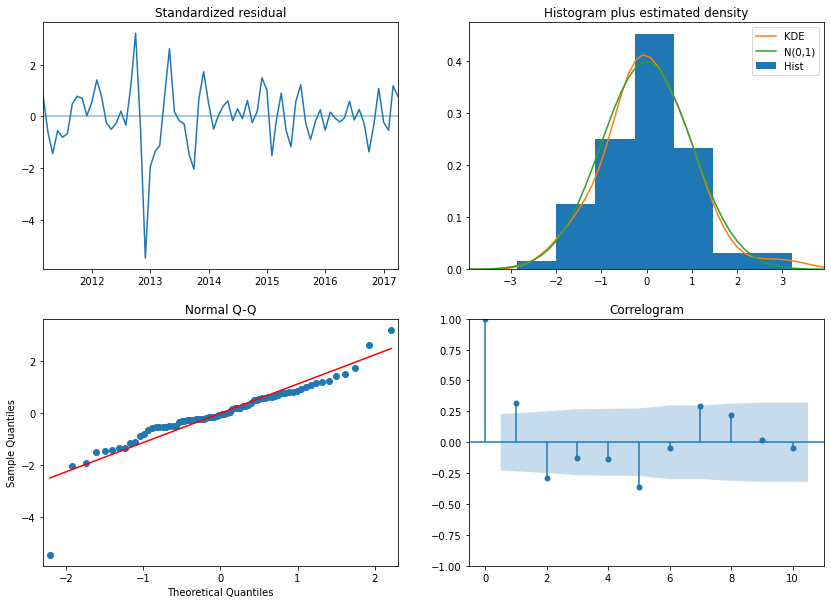

In [76]:
model_11224 = aa_model(train_11224, 4, 2)

RMSE: 13110.209067634056


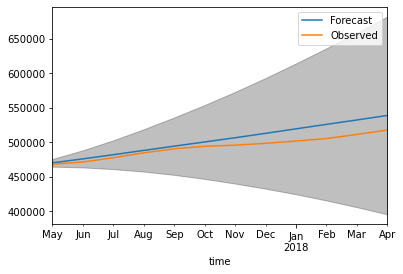

In [77]:
forecast_rmse(model_11224, test_11224)

RMSE: 4742.889414692272


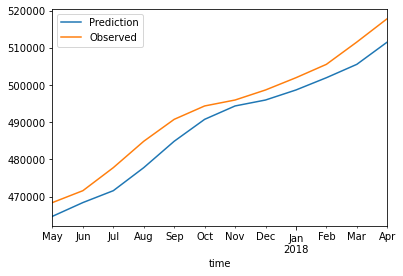

In [78]:
shifted_rmse(ts_11224)

ARIMA model did not perform better than baseline, however the observed values are still within the forecasted confidence intervals. 

In [79]:
model_results = model_results.append({'Zipcode': '11224',
                                      'forecast_rmse': 13110.20,
                                      'base_rmse': 4742.88}, ignore_index = True)

## 11105

In [80]:
ts_11105, train_11105, test_11105 = split(top10, 11105)

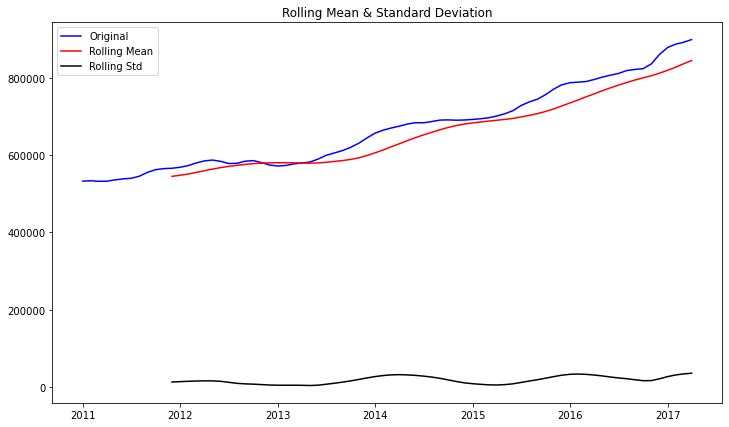

Test Statistic                  3.443588
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64

In [81]:
stationarity_check(train_11105)

In [82]:
ndiffs(train_11105, test='adf')  

2

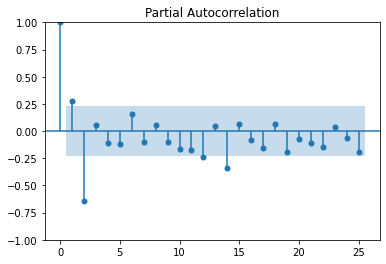

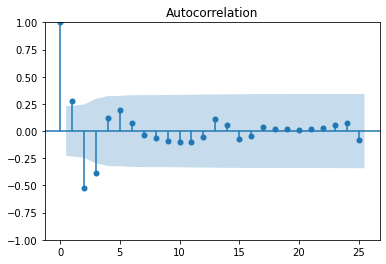

In [83]:
ts_diff = train_11105.diff().diff().dropna()


plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1431.469, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1433.402, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1442.278, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1433.017, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1435.325, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1440.374, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1444.443, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1453.903, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1436.512, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1442.972, Time=0.27 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1453.516, Time=0.25 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.650 seconds


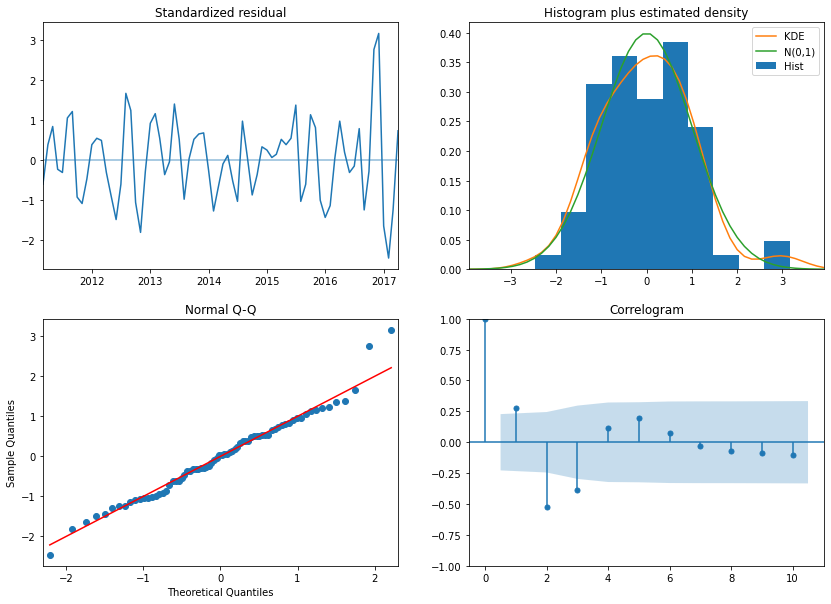

In [84]:
model_11105 = aa_model(train_11105, 2, 3)

RMSE: 45008.30341986746


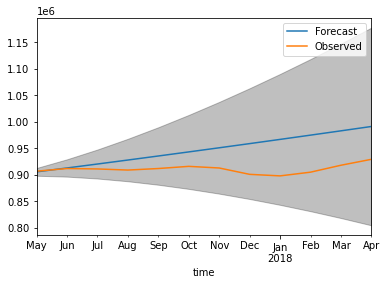

In [85]:
forecast_rmse(model_11105, test_11105)

RMSE: 7287.546454969144


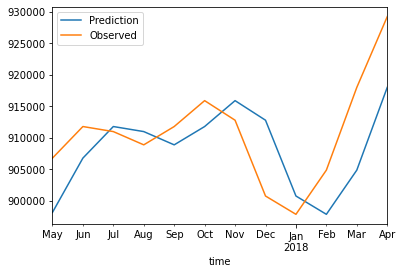

In [86]:
shifted_rmse(ts_11105)

In [87]:
model_results = model_results.append({'Zipcode': '11105',
                                      'forecast_rmse': 45008.30,
                                      'base_rmse': 7287.54}, ignore_index = True)

## 11229

In [88]:
ts_11229, train_11229, test_11229 = split(top10, 11229)

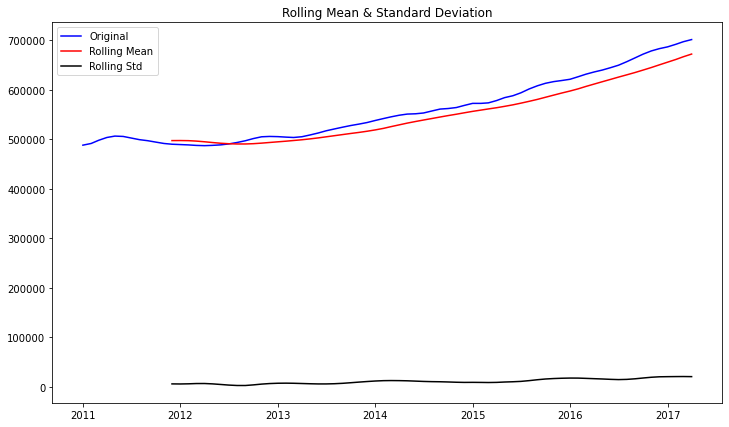

Test Statistic                  1.571894
p-value                         0.997771
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [89]:
stationarity_check(train_11229)

In [90]:
ndiffs(train_11229, test='adf')  

1

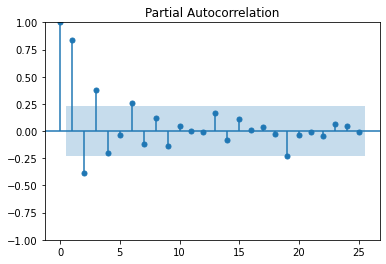

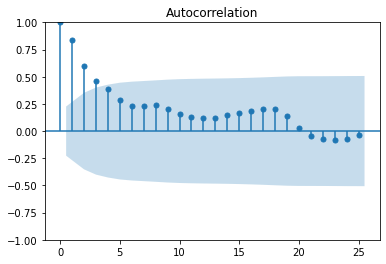

In [91]:
ts_diff = train_11229.diff().dropna()

plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1401.478, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1408.590, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1411.611, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1419.168, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1429.290, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.281, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1398.036, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1580.849, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1708.746, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1429.410, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1390.031, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(3,1,1)(0,0

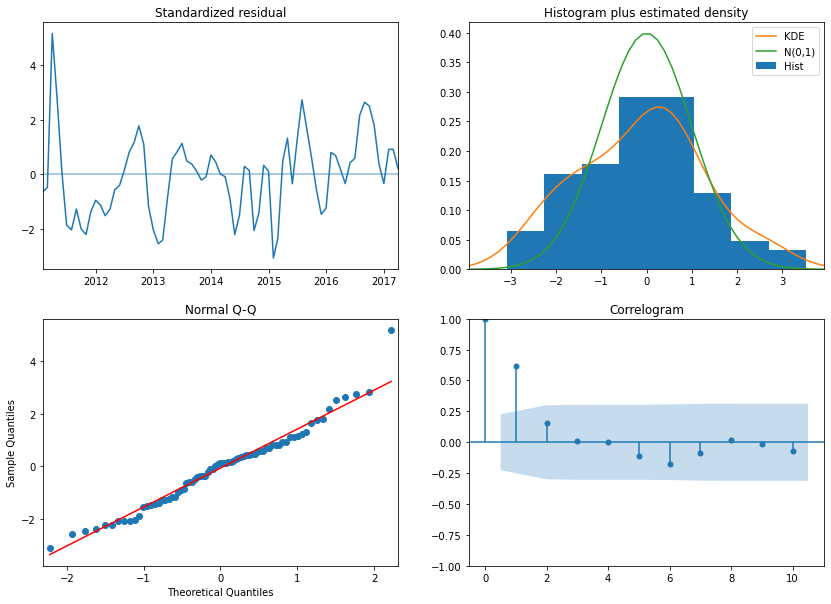

In [92]:
model_11229 = aa_model(train_11229, 3, 3)

RMSE: 13235.197644375146


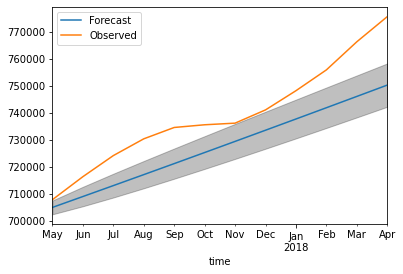

In [93]:
forecast_rmse(model_11229, test_11229)

RMSE: 6870.8320699412625


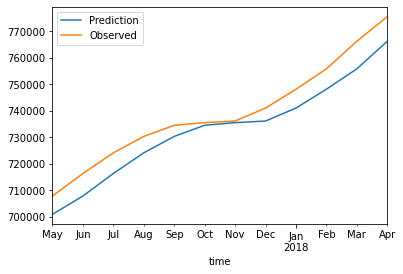

In [94]:
shifted_rmse(ts_11229)

In [95]:
model_results = model_results.append({'Zipcode': '11229',
                                      'forecast_rmse': 13235.19,
                                      'base_rmse': 6870.83}, ignore_index = True)

## 11694

In [96]:
ts_11694, train_11694, test_11694 = split(top10, 11694)

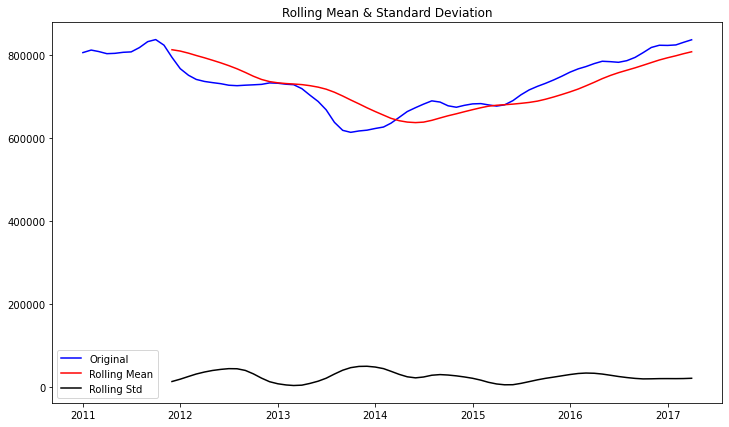

Test Statistic                 -1.679355
p-value                         0.441779
#Lags Used                      8.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [97]:
stationarity_check(train_11694)

In [98]:
ndiffs(train_11694, test='adf')  

2

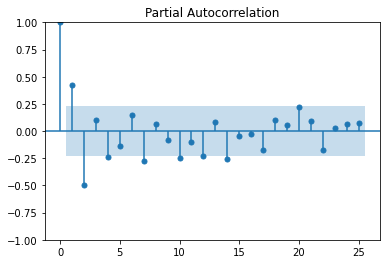

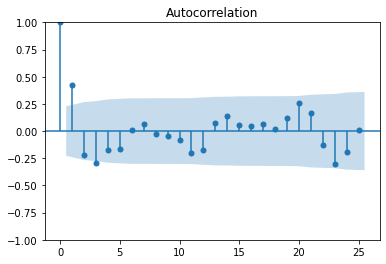

In [99]:
ts_diff = train_11694.diff().diff().dropna()

plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1496.834, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1499.385, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1496.432, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1501.290, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1507.263, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1508.602, Time=0.13 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0] intercept
Total fit time: 0.470 seconds


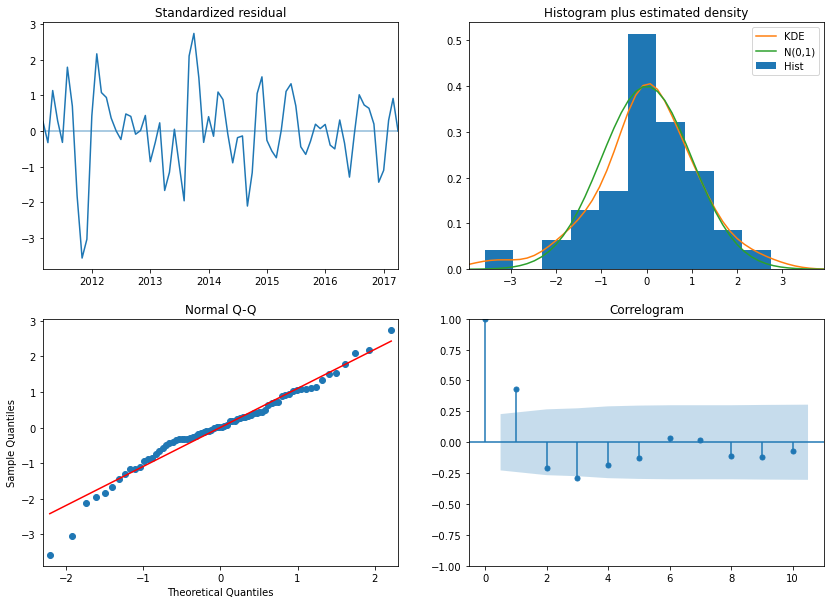

In [100]:
model_11694 = aa_model(train_11694, 2, 1)

RMSE: 7075.3236760500495


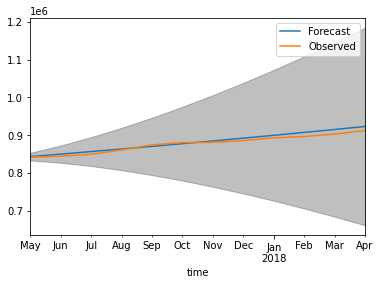

In [101]:
forecast_rmse(model_11694, test_11694)

RMSE: 7198.553095356501


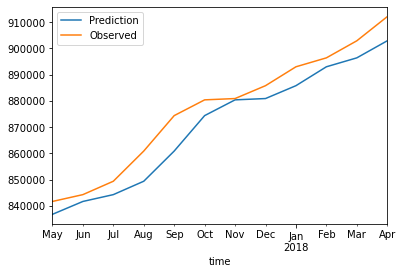

In [102]:
shifted_rmse(ts_11694)

In [103]:
model_results = model_results.append({'Zipcode': '11694',
                                      'forecast_rmse': 7075.32,
                                      'base_rmse': 7198.55}, ignore_index = True)

## 11222

In [104]:
ts_11222, train_11222, test_11222 = split(top10, 11222)

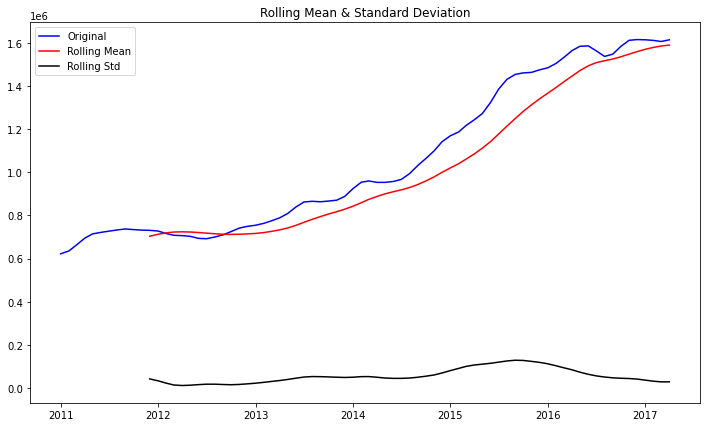

Test Statistic                  0.748843
p-value                         0.990764
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [105]:
stationarity_check(train_11222)

In [106]:
ndiffs(train_11222, test='adf')  

2

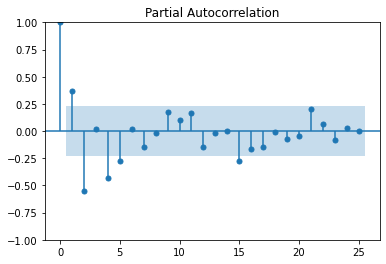

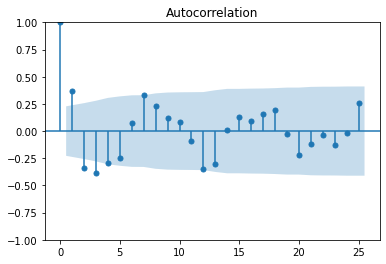

In [107]:
ts_diff = train_11222.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1599.287, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1603.015, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1603.842, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1613.052, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1601.721, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1605.009, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1620.402, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1615.083, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1616.353, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1616.412, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1617.874, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0] interc

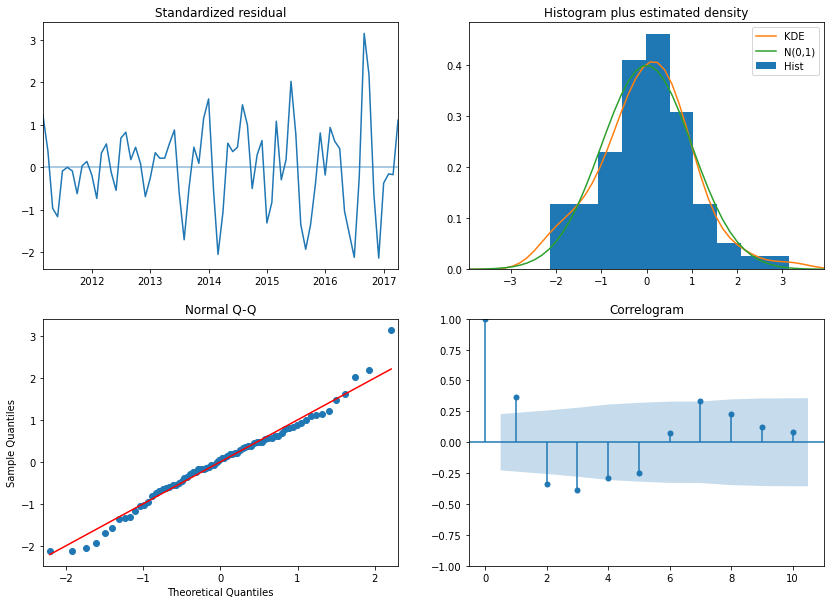

In [108]:
model_11222 = aa_model(train_11222, 4, 3)

RMSE: 21464.65934798968


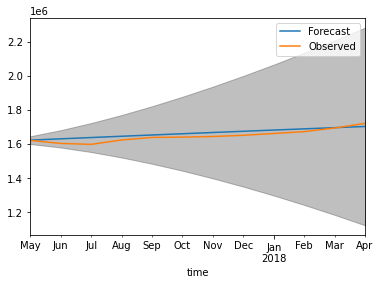

In [109]:
forecast_rmse(model_11222, test_11222)

RMSE: 15125.750670076952


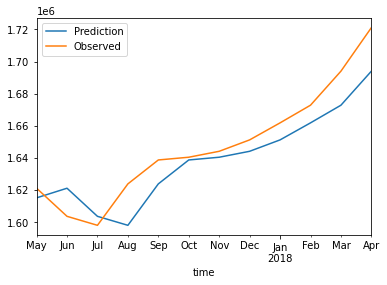

In [110]:
shifted_rmse(ts_11222)

In [111]:
model_results = model_results.append({'Zipcode': '11222',
                                      'forecast_rmse': 21464.65,
                                      'base_rmse': 15125.75}, ignore_index = True)

## 11238

In [112]:
ts_11238, train_11238, test_11238 = split(top10, 11238)

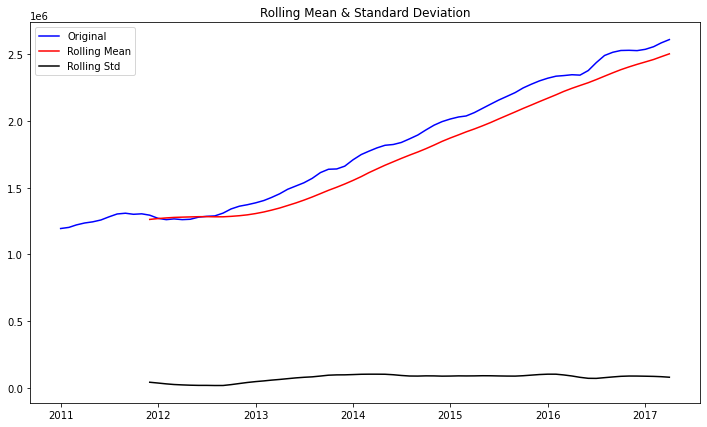

Test Statistic                  0.407642
p-value                         0.981778
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [113]:
stationarity_check(train_11238)

In [114]:
ndiffs(train_11238, test='adf')  

2

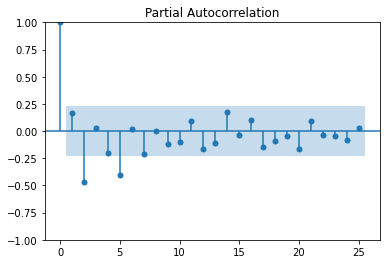

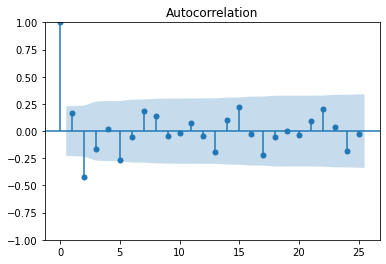

In [115]:
ts_diff = train_11238.diff().diff().dropna()

plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1601.799, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1603.315, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1606.383, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1603.320, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1605.313, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1608.124, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1609.609, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.780 seconds


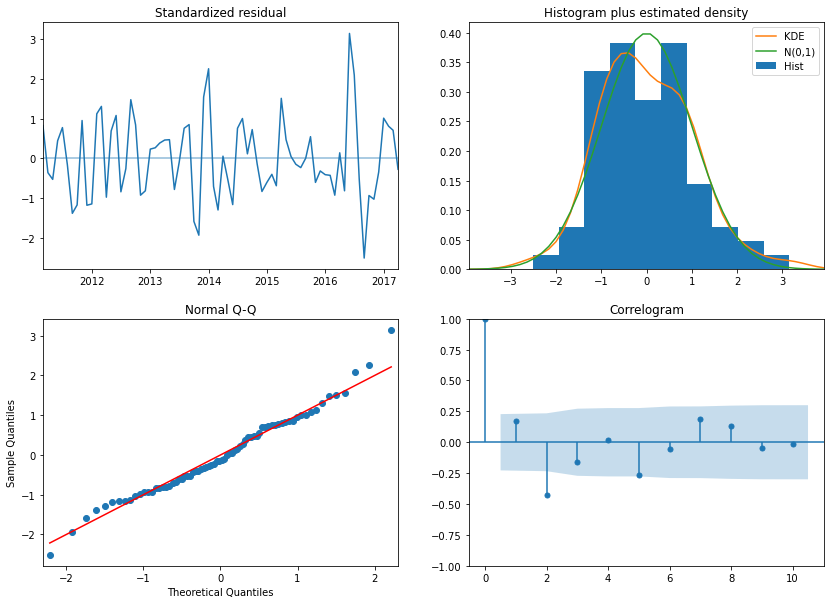

In [116]:
model_11238 = aa_model(train_11238, 2, 2)

RMSE: 32969.39072347842


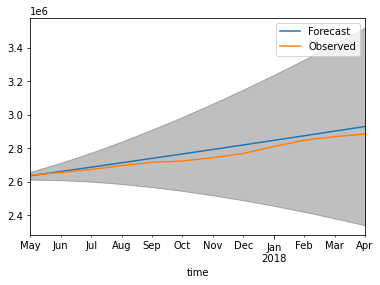

In [117]:
forecast_rmse(model_11238, test_11238)

RMSE: 24660.173694981684


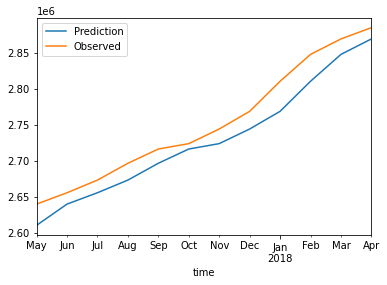

In [118]:
shifted_rmse(ts_11238)

In [119]:
model_results = model_results.append({'Zipcode': '11238',
                                      'forecast_rmse': 32969.39,
                                      'base_rmse': 24660.17}, ignore_index = True)

## 11102

In [120]:
ts_11102, train_11102, test_11102 = split(top10, 11102)

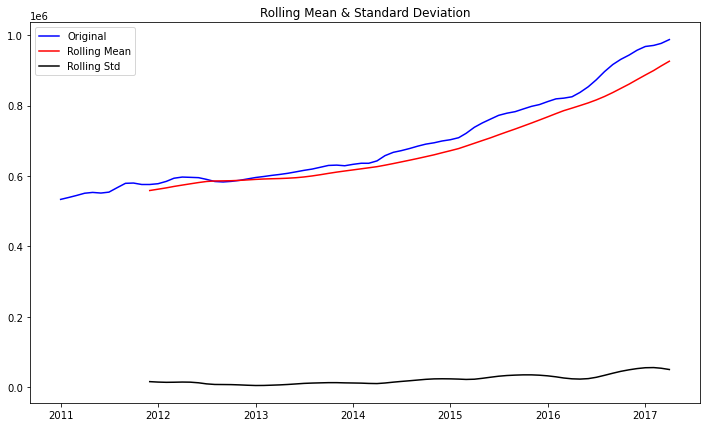

Test Statistic                  3.867860
p-value                         1.000000
#Lags Used                      7.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64

In [121]:
stationarity_check(train_11102)

In [122]:
ndiffs(train_11102, test='adf')  

2

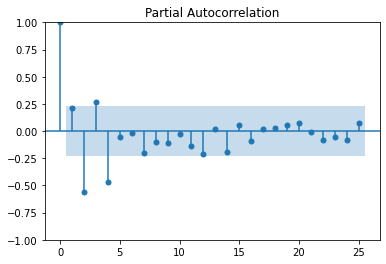

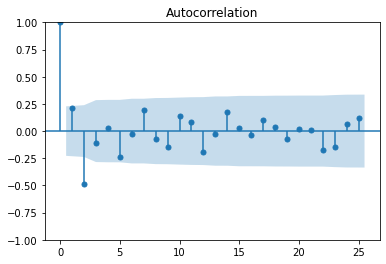

In [123]:
ts_diff = train_11102.diff().diff().dropna()

plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1439.803, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1442.551, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1453.728, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1441.807, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1444.889, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1457.554, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1450.406, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1455.789, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1444.230, Time=0.35 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1455.393, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1456.642, Time=0.14 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1441.846, Time=0.34 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1471.587, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1449.138, Time=0.24 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.580 seconds

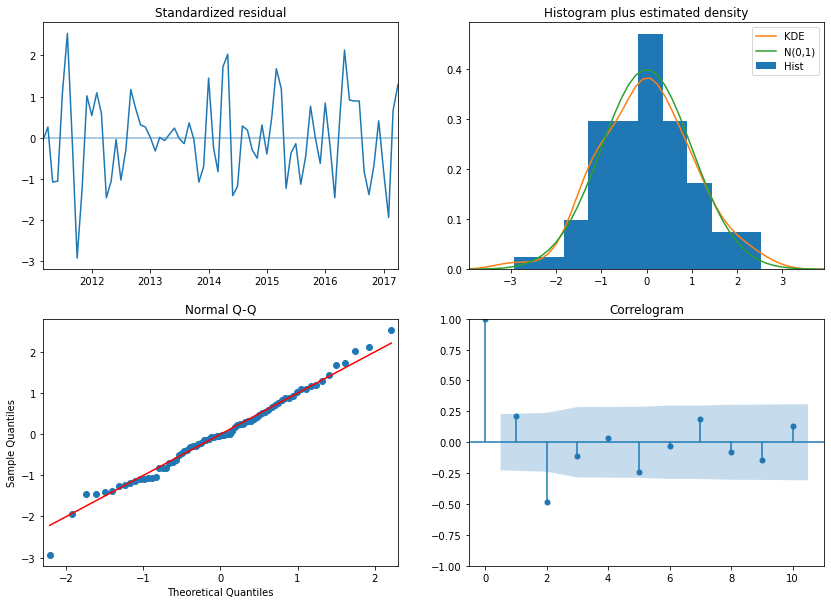

In [124]:
model_11102 = aa_model(train_11102, 4, 2)

RMSE: 24581.23661476507


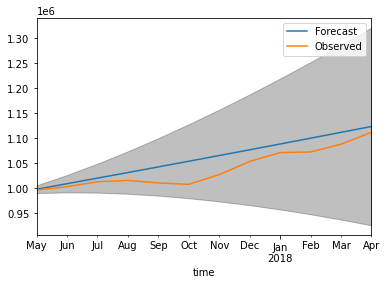

In [125]:
forecast_rmse(model_11102, test_11102)

RMSE: 14333.294573591005


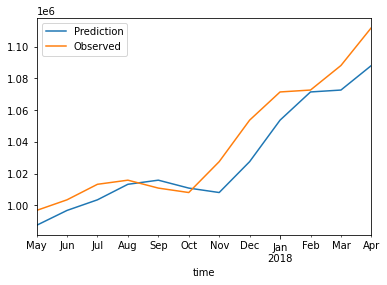

In [126]:
shifted_rmse(ts_11102)

In [127]:
model_results = model_results.append({'Zipcode': '11102',
                                      'forecast_rmse': 24581.23,
                                      'base_rmse': 14333.29}, ignore_index = True)

## 11211

In [128]:
ts_11211, train_11211, test_11211 = split(top10, 11211)

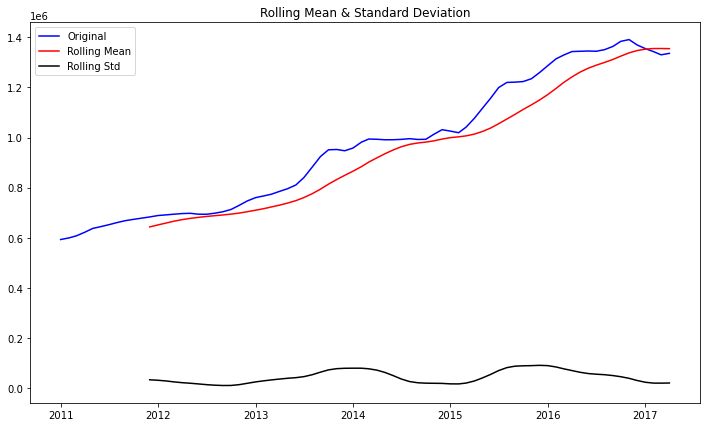

Test Statistic                  0.314900
p-value                         0.978018
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64

In [129]:
stationarity_check(train_11211)

In [130]:
ndiffs(train_11211, test='adf')  

2

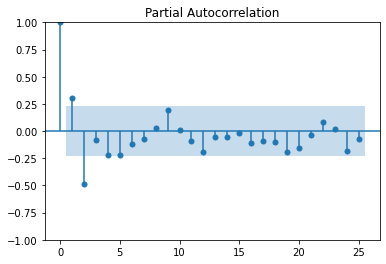

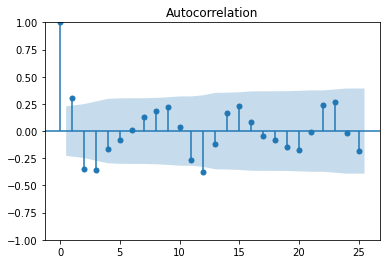

In [131]:
ts_diff = train_11211.diff().diff().dropna()

plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1576.543, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1578.885, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1580.676, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1584.459, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1578.802, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1580.843, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1586.034, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1585.834, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1585.990, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1589.036, Time=0.23 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.270 seconds


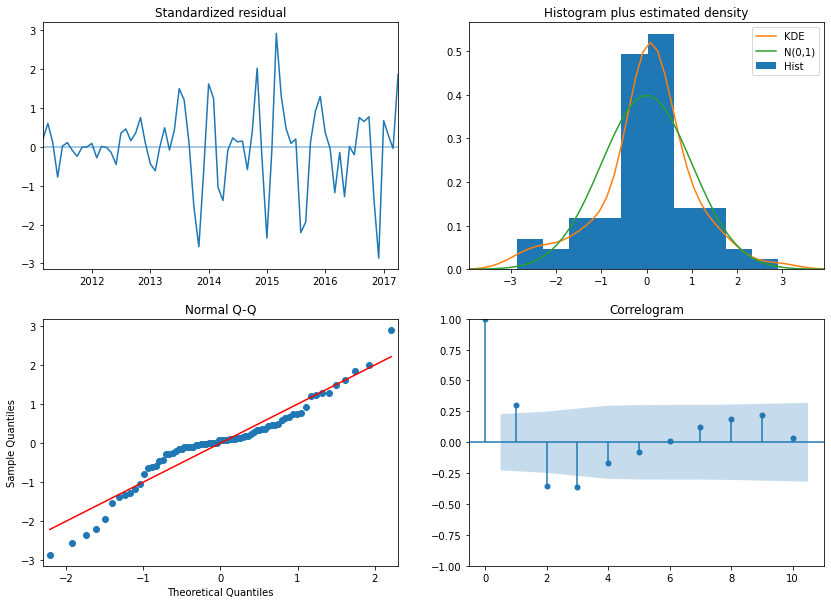

In [132]:
model_11211 = aa_model(train_11211, 2, 3)

RMSE: 107397.58732603113


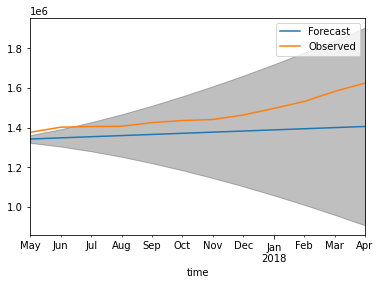

In [133]:
forecast_rmse(model_11211, test_11211)

RMSE: 28681.628847283646


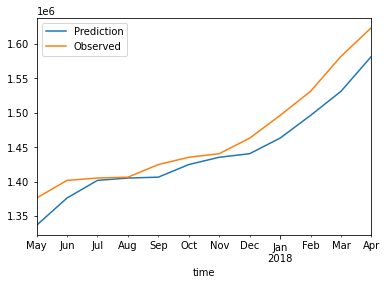

In [134]:
shifted_rmse(ts_11211)

In [135]:
model_results = model_results.append({'Zipcode': '11211',
                                      'forecast_rmse': 107397.58,
                                      'base_rmse': 28681.62}, ignore_index = True)

# Results

In [136]:
model_results

,Zipcode,base_rmse,forecast_rmse
0,11355,6087.35,4310.58
1,11354,8132.29,5819.31
2,11224,4742.88,13110.20
3,11105,7287.54,45008.30
4,11229,6870.83,13235.19
5,11694,7198.55,7075.32
6,11222,15125.75,21464.65
7,11238,24660.17,32969.39
8,11102,14333.29,24581.23
9,11211,28681.62,107397.58


Only 3 models performed better than baseline model. To filter down our selection, I will select models that have the smallest gap between baseline rmse and forecasted rmse.

In [137]:
model_results['rmse_diff'] = model_results['forecast_rmse'] - model_results['base_rmse']

In [138]:
model_results.sort_values('rmse_diff', ascending = True)

,Zipcode,base_rmse,forecast_rmse,rmse_diff
1,11354,8132.29,5819.31,-2312.98
0,11355,6087.35,4310.58,-1776.77
5,11694,7198.55,7075.32,-123.23
6,11222,15125.75,21464.65,6338.90
4,11229,6870.83,13235.19,6364.36
7,11238,24660.17,32969.39,8309.22
2,11224,4742.88,13110.20,8367.32
8,11102,14333.29,24581.23,10247.94
3,11105,7287.54,45008.30,37720.76
9,11211,28681.62,107397.58,78715.96


Based on the following criteria:
* High 3 year ROI
* High ROI during 2007-2011
* Forecasting performance compared to baseline model

The top 5 zipcodes to invest in are:
* 11354
* 11355
* 11694
* 11222
* 11229

## Forecasting future prices

Now that I have made my final selections, I will forecast house prices 1 year ahead and calculate expected ROI.

In [139]:
def forecast_plot(model, observed, period):
    '''
    Make predictions on model for a specific time period and plot along with
    observed values.
    '''
    # predictions are returned as an array, will need to set up time series 
    # index 
    forecast_range = pd.date_range(start = '05-01-2018', 
                                   periods = period, 
                                   freq = 'MS')
    # compute forecasted values and confidence intervals 
    prediction, confint = model.predict(n_periods=12, 
                                        return_conf_int=True)
    
    # add time series index to predictions and subset observed time series
    forecast = pd.Series(prediction, index = forecast_range)
    obs = observed['2011-01':]

    # plot observed values with forecast
    fig, ax = plt.subplots(figsize = (14,10))
    ax.plot(obs, label = 'Observed')
    ax.plot(forecast, label = 'Forecast')
    ax.legend(loc = 'upper left')
    ax.fill_between(forecast_range,
                    confint[:,0],
                    confint[:,1], color='k', alpha=0.25);
    # calculate ROI
    cost = observed['value'].values[-1]
    ret = prediction[-1]
    max_ret = confint[-1][1]
    min_ret = confint[-1][0]
    roi = round((ret - cost) / cost, 3)
    max_roi = round((max_ret - cost) / cost, 3)
    min_roi = round((min_ret - cost) / cost, 3)
    print(f'ROI:{roi}', f'Max ROI:{max_roi}', f'Min ROI:{min_roi}', sep = '\n')
    print(f'+/-:{max_roi - roi}')

Making use of .update() from auto_arima to add test set to model as new observations. After updating model forecasts will now be able to make predictions on the next period following the test data.

### 11354 forecast

In [140]:
model_11354.update(test_11354)

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

ROI:0.077
Max ROI:0.174
Min ROI:-0.019
+/-:0.09699999999999999


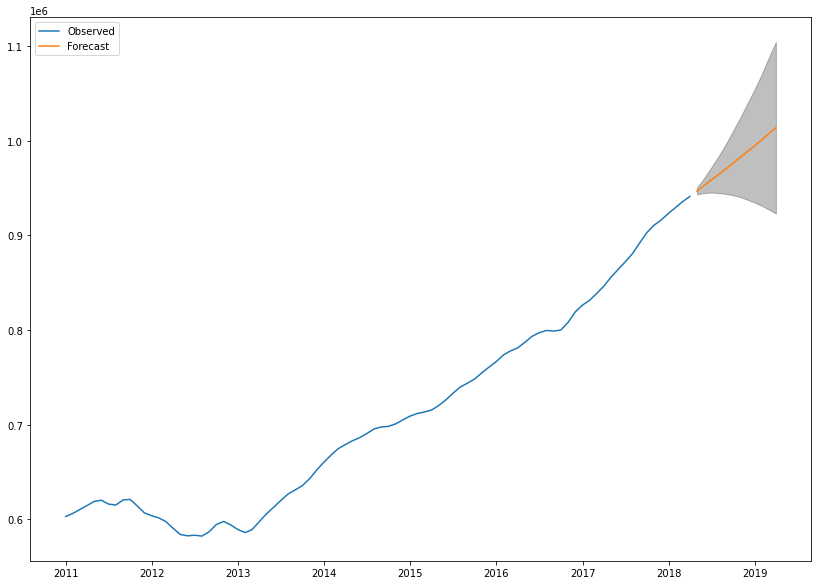

In [141]:
forecast_plot(model_11354, ts_11354, 12)

### 11355 forecast

In [142]:
model_11355.update(test_11355)

ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True)

ROI:0.105
Max ROI:0.182
Min ROI:0.027
+/-:0.077


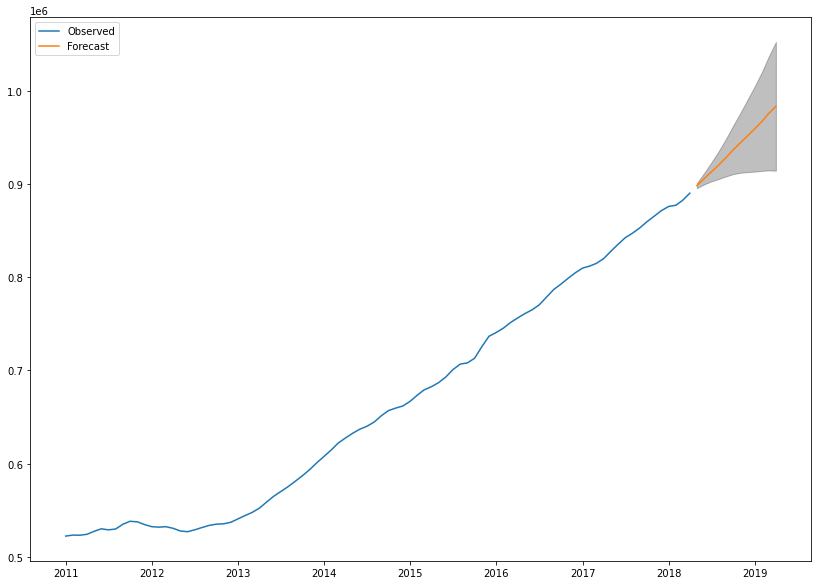

In [143]:
forecast_plot(model_11355, ts_11355, 12)

### 11694 forecast

ROI:0.133
Max ROI:0.42
Min ROI:-0.154
+/-:0.287


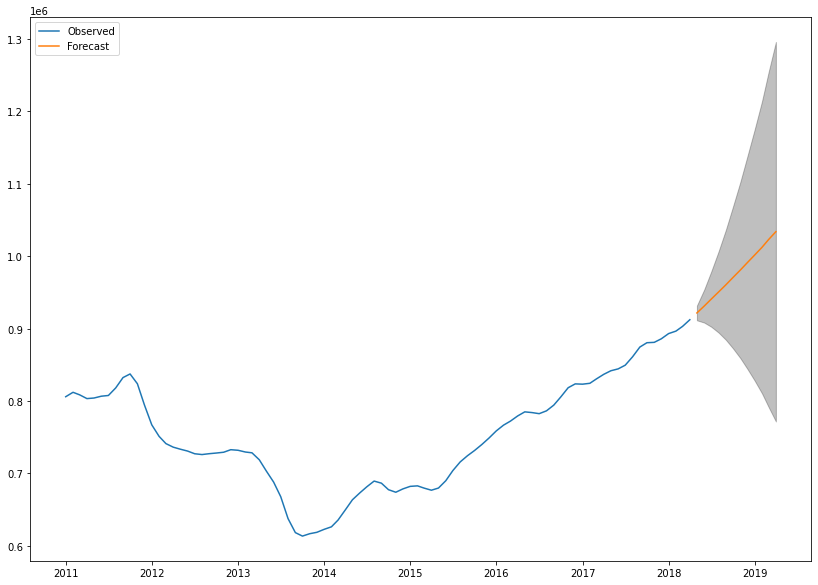

In [144]:
model_11694.update(test_11694)
forecast_plot(model_11694, ts_11694, 12)

### 11222 forecast

ROI:0.186
Max ROI:0.523
Min ROI:-0.152
+/-:0.337


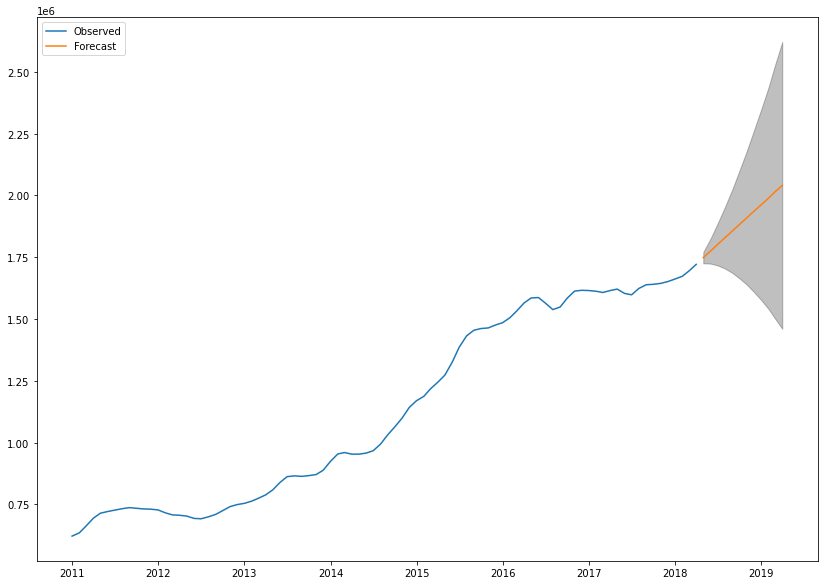

In [145]:
model_11222.update(test_11222)
forecast_plot(model_11222, ts_11222, 12)

### 11229 forecast

ROI:0.064
Max ROI:0.074
Min ROI:0.053
+/-:0.009999999999999995


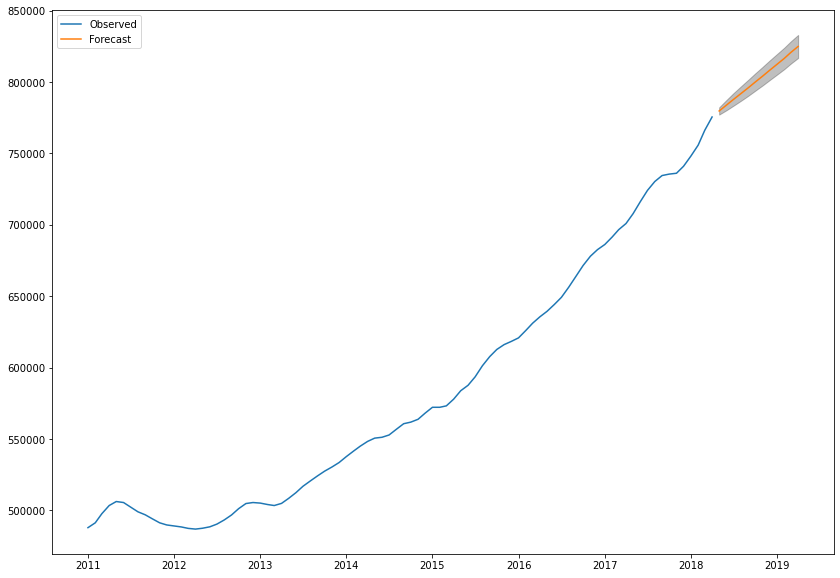

In [146]:
model_11229.update(test_11229)
forecast_plot(model_11229, ts_11229, 12)

I choose to set forecast horizon to 1 year due to the fact that as forecast horizon increases, confidence intervals of forecast will also increase. Models can be updated periodically with new observations to keep forecast values as accurate as possible.

# Conclusion 

The top 5 zipcodes to invest in from safe to risky are:
* 11229 (1 year ROI: 6.4% +/- 0.9%)
* 11355 (1 year ROI: 10.5% +/- 7.7%)
* 11354 (1 year ROI: 7.7% +/- 9.6%)
* 11694 (1 year ROI: 13.3% +/- 28.7%)
* 11222 (1 year ROI: 18.6% +/- 33.7%)

## Limitations

Forecasts are based on previous performance . There are many other factors that impact house prices such as GDP, mortgage interest rates, unemployment rates, inflation, and a host of other economic factors. 

## Next steps

Other modeling methods can be test out, such as ARIMAX which can include external factors, such as the ones listed above into the model and improve the quality of forecasts.

# Graphs for presentation 

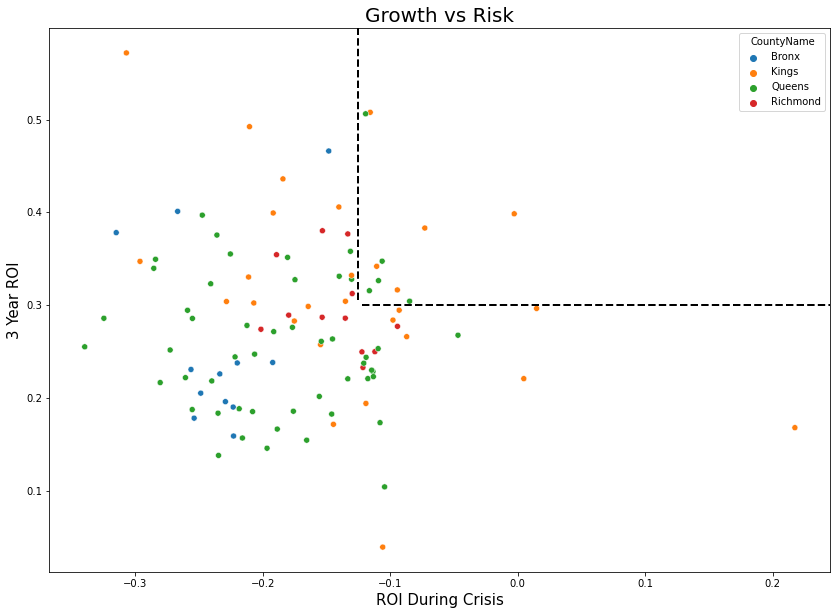

In [147]:
fig, ax = plt.subplots(figsize = (14,10))
sns.scatterplot(x = '07_11_roi', y = '3_yr_roi', hue = 'CountyName', data = ny_df, ax= ax)
ax.axvline(x = -0.125, ymin = 0.5, color = 'k', linestyle='--', lw=2)
ax.axhline(y = 0.3, xmin = 0.4, color = 'k', linestyle='--', lw=2)
ax.set_title('Growth vs Risk', fontsize = 20)
ax.set_ylabel('3 Year ROI', fontsize = 15)
ax.set_xlabel('ROI During Crisis', fontsize = 15);

In [148]:
final10 = ny_df[(ny_df['07_11_roi'] > -0.125) & (ny_df['3_yr_roi'] > 0.3)]

In [149]:
pplot = final10[['RegionName', '3_yr_roi', '07_11_roi']]

In [150]:
pplot.set_index('RegionName', inplace = True)

In [151]:
pplot['07_11_roi'] = pplot['07_11_roi'].abs()

<ipython-input-151-94a9d1ae9e91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pplot['07_11_roi'] = pplot['07_11_roi'].abs()


In [152]:
pplot.sort_values(['3_yr_roi'], ascending = True, inplace = True)

<ipython-input-152-9d2f0702e747>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pplot.sort_values(['3_yr_roi'], ascending = True, inplace = True)


In [153]:
from matplotlib.pyplot import text

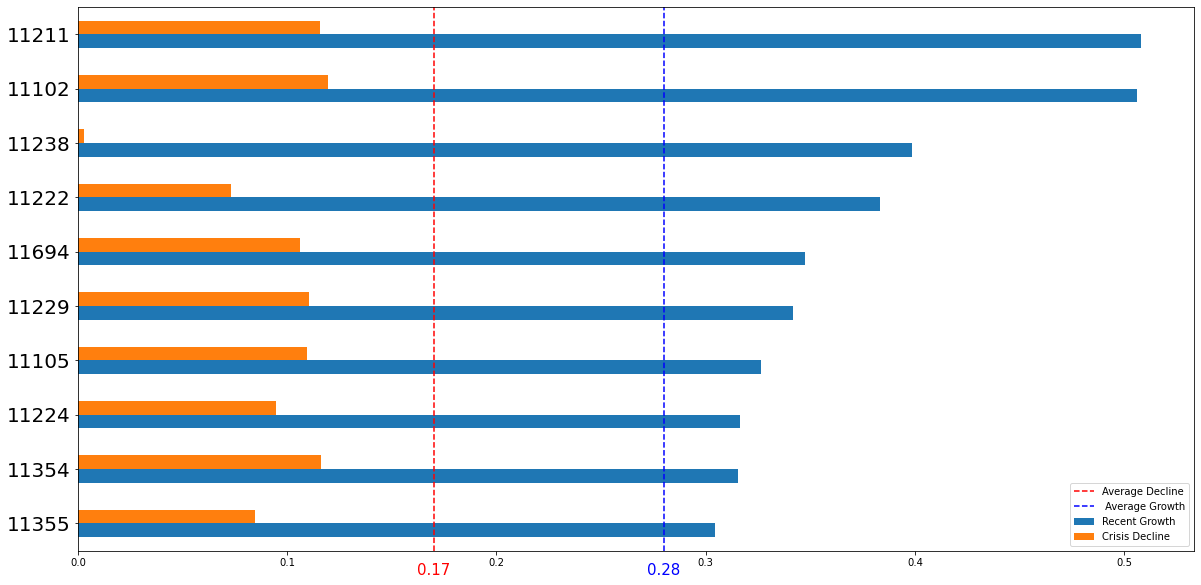

In [154]:
pplot.plot.barh(figsize =(20,10))
plt.axvline(x = 0.17, color = 'r', linestyle = '--')
plt.axvline(x = 0.28, color = 'b', linestyle = '--')
plt.ylabel("")
plt.legend(['Average Decline', ' Average Growth', 'Recent Growth', 'Crisis Decline'])
plt.yticks(fontsize = 20)
text(x = 0.17, y = -1, s = '0.17', ha = 'center', va = 'bottom', color = 'r', fontsize = 15)
text(x = 0.28, y = -1, s = '0.28', ha = 'center', va = 'bottom', color = 'b', fontsize = 15);

In [155]:
shifted_11355 = ts_11355.shift()
shifted_pred = shifted_11355['2017-05-01':].value 

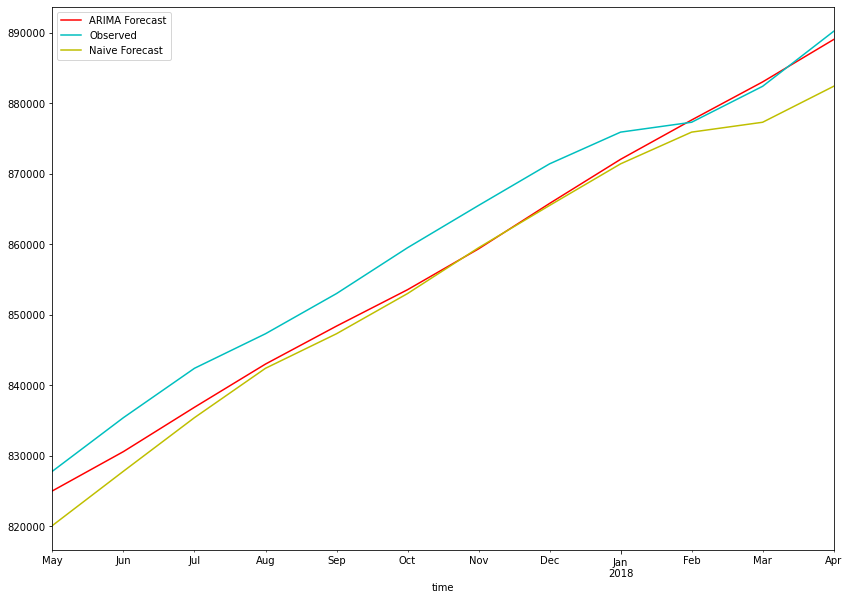

In [156]:
fig, ax = plt.subplots(figsize = (14,10))
prediction.plot(label = 'ARIMA Forecast', legend = True, ax = ax, color = 'r')
test_11355.plot(y = 'value', label = 'Observed', legend = True, ax=ax, color = 'c')
shifted_pred.plot (label = 'Naive Forecast', legend = True, ax = ax, color = 'y');

In [157]:
forecast_range = pd.date_range(start = '05-01-2018', 
                                   periods = 12, 
                                   freq = 'MS')

In [158]:
prediction_11229, confint_11229 = model_11229.predict(n_periods=12, return_conf_int=True)
forecast_11229 = pd.Series(prediction_11229, index = forecast_range)
obs_11229 = ts_11229['2015-01':]

prediction_11355, confint_11355 = model_11355.predict(n_periods=12, return_conf_int=True)
forecast_11355 = pd.Series(prediction_11355, index = forecast_range)
obs_11355 = ts_11355['2015-01':]

prediction_11354, confint_11354 = model_11354.predict(n_periods=12, return_conf_int=True)
forecast_11354 = pd.Series(prediction_11354, index = forecast_range)
obs_11354 = ts_11354['2015-01':]

prediction_11694, confint_11694 = model_11694.predict(n_periods=12, return_conf_int=True)
forecast_11694 = pd.Series(prediction_11694, index = forecast_range)
obs_11694 = ts_11694['2015-01':]

prediction_11222, confint_11222 = model_11222.predict(n_periods=12, return_conf_int=True)
forecast_11222 = pd.Series(prediction_11222, index = forecast_range)
obs_11222 = ts_11222['2015-01':]

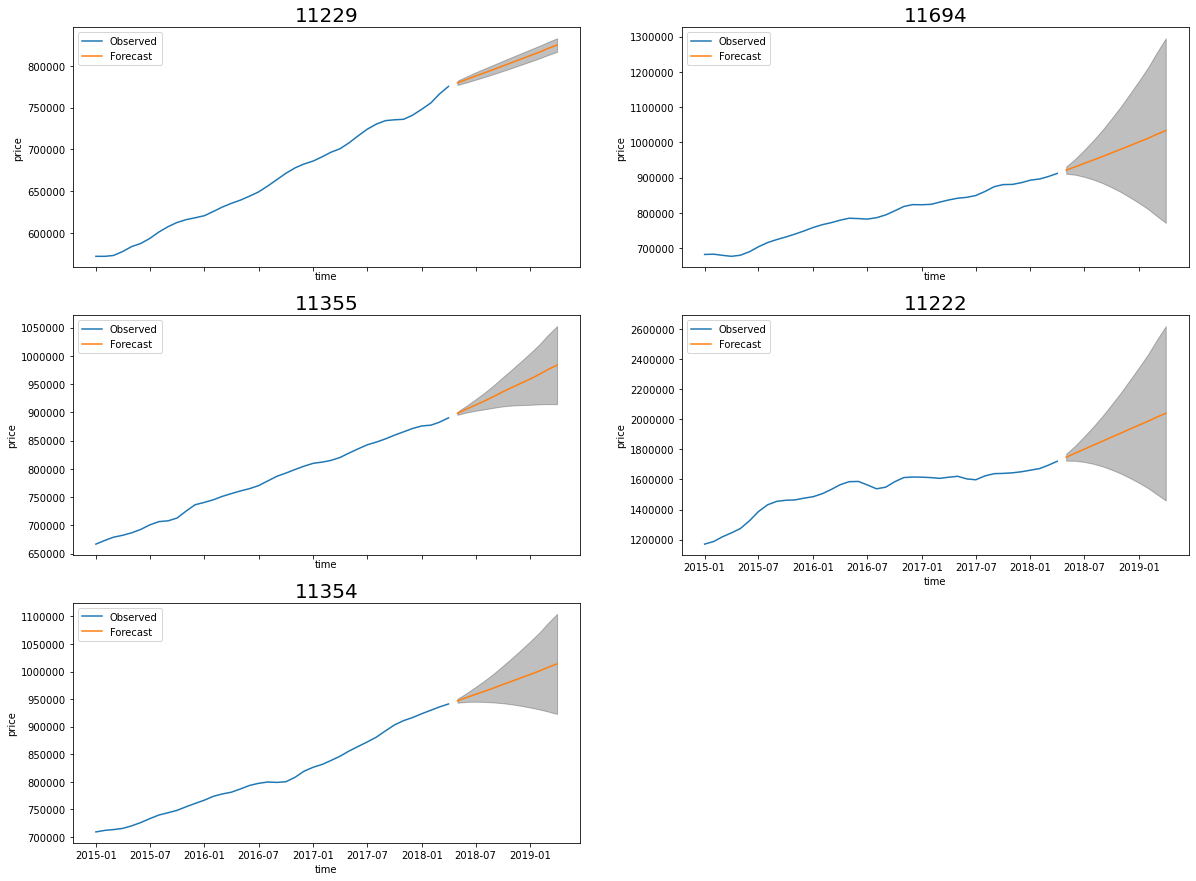

In [159]:
fig, ax = plt.subplots(3,2, figsize = (20,15), sharex = True)
fig.delaxes(ax[2][1])

ax[0][0].plot(obs_11229, label = 'Observed')
ax[0][0].plot(forecast_11229, label = 'Forecast')
ax[0][0].legend(loc = 'upper left')
ax[0][0].fill_between(forecast_range,
                confint_11229[:,0],
                confint_11229[:,1], color='k', alpha=0.25)

ax[0][0].set_title('11229', fontsize = 20)
ax[0][0].ticklabel_format(useOffset=False, style='plain', axis='y');


ax[1][0].plot(obs_11355, label = 'Observed')
ax[1][0].plot(forecast_11355, label = 'Forecast')
ax[1][0].legend(loc = 'upper left')
ax[1][0].fill_between(forecast_range,
                confint_11355[:,0],
                confint_11355[:,1], color='k', alpha=0.25)

ax[1][0].set_title('11355', fontsize = 20)
ax[1][0].ticklabel_format(useOffset=False, style='plain', axis='y');


ax[2][0].plot(obs_11354, label = 'Observed')
ax[2][0].plot(forecast_11354, label = 'Forecast')
ax[2][0].legend(loc = 'upper left')
ax[2][0].fill_between(forecast_range,
                confint_11354[:,0],
                confint_11354[:,1], color='k', alpha=0.25)

ax[2][0].set_title('11354', fontsize = 20)
ax[2][0].ticklabel_format(useOffset=False, style='plain', axis='y');


ax[0][1].plot(obs_11694, label = 'Observed')
ax[0][1].plot(forecast_11694, label = 'Forecast')
ax[0][1].legend(loc = 'upper left')
ax[0][1].fill_between(forecast_range,
                confint_11694[:,0],
                confint_11694[:,1], color='k', alpha=0.25)

ax[0][1].set_title('11694', fontsize = 20)
ax[0][1].ticklabel_format(useOffset=False, style='plain', axis='y');


ax[1][1].plot(obs_11222, label = 'Observed')
ax[1][1].plot(forecast_11222, label = 'Forecast')
ax[1][1].legend(loc = 'upper left')
ax[1][1].fill_between(forecast_range,
                confint_11222[:,0],
                confint_11222[:,1], color='k', alpha=0.25)

ax[1][1].set_title('11222', fontsize = 20)
ax[1][1].ticklabel_format(useOffset=False, style='plain', axis='y');

for a in ax.flat:
    a.set(xlabel = 'time', ylabel = 'price')

ax[1][1].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False)

In [160]:
table = model_results.sort_values('rmse_diff', ascending = True, ignore_index = True)

In [161]:
table.rename(columns = {'base_rmse': 'Naive Error', 'forecast_rmse': 'ARIMA Error', 'rmse_diff': 'Difference'}, inplace = True)

In [162]:
def highlight_neg(s):
    if s.dtype == object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:black' 
            for cell in is_neg]

In [163]:
table.style.apply(lambda x: ['background: lightgreen' if x.name in [0,1,2,3,4] 
                              else '' for i in x], axis=1)\
            .apply(highlight_neg)

,Zipcode,Naive Error,ARIMA Error,Difference
0,11354,8132.290000,5819.310000,-2312.980000
1,11355,6087.350000,4310.580000,-1776.770000
2,11694,7198.550000,7075.320000,-123.230000
3,11222,15125.750000,21464.650000,6338.900000
4,11229,6870.830000,13235.190000,6364.360000
5,11238,24660.170000,32969.390000,8309.220000
6,11224,4742.880000,13110.200000,8367.320000
7,11102,14333.290000,24581.230000,10247.940000
8,11105,7287.540000,45008.300000,37720.760000
9,11211,28681.620000,107397.580000,78715.960000
